In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
import random
from random import sample

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
#load the cell counts from the supplmental_6
A549_counts = pd.read_csv('../Supplemental_6/outputs/A549_WG_Screen_cell_count.csv.gz')
DMEM_counts = pd.read_csv('../Supplemental_6/outputs/HeLa_DMEM_WG_Screen_cell_count.csv.gz')
HPLM_counts = pd.read_csv('../Supplemental_6/outputs/HeLa_HPLM_WG_Screen_cell_count.csv.gz')

#load barcodes used in experiment
guide_df = pd.read_csv('../common_files/Barcodes.csv')
guide_list = list(guide_df['sgRNA'])

# Import the guide-level profiles
A549_df_guide = pd.read_csv("../Profile_Aggregation/outputs/20200805_A549_WG_Screen_guide_normalized_feature_select_merged_median_ALLBATCHES___CP186___ALLWELLS.csv.gz")
DMEM_df_guide = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS.csv.gz")
DMEM_df_guide = DMEM_df_guide[DMEM_df_guide['Metadata_Foci_Barcode_MatchedTo_Barcode'].isin(guide_list)]

HPLM_df_guide = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___HPLM___ALLWELLS.csv.gz")
HPLM_df_guide = HPLM_df_guide[HPLM_df_guide['Metadata_Foci_Barcode_MatchedTo_Barcode'].isin(guide_list)]

# Load p_values from the hit calling process
A549_df_p_values = pd.read_csv('../Hit_Calling/outputs/A549_significant_features_mann_whitney_p_values.csv.gz').set_index('Gene')
DMEM_df_p_values = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz').set_index('Gene')
HPLM_df_p_values = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_significant_features_mann_whitney_p_values.csv.gz').set_index('Gene')
    
# Load hits lists
A549_whole_cell_hits = pd.read_csv('../2_A549_WGS_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
A549_comp_spec_hits = pd.read_csv('../2_A549_WGS_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
A549_all_hits = pd.concat([A549_whole_cell_hits,A549_comp_spec_hits])
A549_hit_list = list(A549_comp_spec_hits.Gene) + list(A549_whole_cell_hits.Gene)
A549_df_guide_hits = A549_df_guide[A549_df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(A549_hit_list)]

DMEM_whole_cell_hits = pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
DMEM_comp_spec_hits = pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
DMEM_all_hits = pd.concat([DMEM_whole_cell_hits,DMEM_comp_spec_hits])
DMEM_hit_list = list(DMEM_comp_spec_hits.Gene) + list(DMEM_whole_cell_hits.Gene)
DMEM_df_guide_hits = DMEM_df_guide[DMEM_df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(DMEM_hit_list)]

HPLM_whole_cell_hits = pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
HPLM_comp_spec_hits = pd.read_csv('../3_HeLa_WGS_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
HPLM_all_hits = pd.concat([HPLM_whole_cell_hits,HPLM_comp_spec_hits])
HPLM_hit_list = list(HPLM_comp_spec_hits.Gene) + list(HPLM_whole_cell_hits.Gene)
HPLM_df_guide_hits = HPLM_df_guide[HPLM_df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(HPLM_hit_list)]


In [4]:
def perform_pca(df_guide_hits, condition):
    df_temp = df_guide_hits.copy(deep=True)
    df_temp['Gene'] = df_temp['Metadata_Foci_Barcode_MatchedTo_GeneCode'] + ' ' + df_temp['Metadata_Foci_Barcode_MatchedTo_Barcode']
    order = ['Gene']+list(df_temp.columns[:-1])
    df_temp = df_temp[order]
    df_temp = df_temp.drop(columns=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']).set_index('Gene')
    
    # Perform principal component analysis on hit lists
    pca = PCA()
    pca.fit(df_temp)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 70% variation
    PCA_lookup = {}
    for i in range(len(x)):
        distance = abs(.7-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 70% variation is {component}')
    # Perform principal component analysis and select components representing 80% of variation in data
    pca = PCA(n_components=component)
    df_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
    df_pca = df_pca.reset_index()
    df_pca[['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']] = df_pca.Gene.str.split(' ', expand = True)
    order = ['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']+list(df_pca.columns[1:-2])
    df_pca = df_pca[order]
    return df_pca

In [5]:
A549_pca_df = perform_pca(A549_df_guide_hits, 'A549')
HeLa_DMEM_pca_df = perform_pca(DMEM_df_guide_hits, 'HeLa_DMEM')
HeLa_HPLM_pca_df = perform_pca(HPLM_df_guide_hits, 'HeLa_HPLM')

HeLa_HPLM_pca_df.head()

For A549, principal component representing closest to 70% variation is 155
For HeLa_DMEM, principal component representing closest to 70% variation is 133
For HeLa_HPLM, principal component representing closest to 70% variation is 88


Metadata_Foci_Barcode_MatchedTo_GeneCode  \
0                                     AAAS   
1                                     AAAS   
2                                     AAAS   
3                                     AAAS   
4                                    AAED1   

  Metadata_Foci_Barcode_MatchedTo_Barcode         0         1         2  \
0                    ATATGAGCACAATAACGAGC -1.163385 -5.728409  3.070879   
1                    CCCAGGGTGAGACAGCACTT -4.496428 -5.062255 -1.693347   
2                    GGCCCATCGACAGAGTGCCA  9.226812  0.521240  6.470384   
3                    TGAAGGCAGTTCTTGTGCCA -5.345238 -9.860936  9.898442   
4                    CATCTGCAAGGAATACGTAG -2.157293  4.190401 -5.738328   

          3         4         5          6         7  ...        78        79  \
0  0.696601  2.125422  1.797336  10.768735  0.874592  ... -0.742433  1.319737   
1  2.777164  0.629967 -0.505888  -1.140747 -0.804788  ... -0.551822 -0.006085   
2 -5.659139 -2.101629 -5.111026  -2.499369 -8.703125  ... -0.048321 -1.652174   
3 -7.650052 -2.602527 -0.670784  -1.401005 -2.720180  ...  0.184739  0.361074   
4 -1.156586 -1.633422  3.460015   0.756262 -0.018421  ...  0.092145 -0.435709   

         80        81        82        83        84        85        86  \
0  0.608173 -0.072654  0.907232  0.114353  0.967928  1.147520 -1.410942   
1  0.875926 -0.195919 -0.270674  0.378118 -0.331994  0.248379 -0.125204   
2 -0.123766  0.365150 -0.209205  0.489843 -0.533540  0.837643  0.424002   
3 -0.230142 -1.015917 -0.484553  1.236837 -0.376663  1.004867  0.177022   
4 -0.808044  0.284281  0.066562  0.031375 -0.484267 -0.882890 -1.138256   

         87  
0  1.403380  
1  0.230023  
2 -1.663672  
3  1.213861  
4  0.798425  

[5 rows x 90 columns]

In [10]:
# Function to calculate correlations, cluster and draw heatmap 
def heat_map(data,title,file_name,font_scale=0.8):
        corr = data.corr()
        sns.set(font_scale=font_scale,rc={'figure.figsize':(30,30)})
        plt.clf()
        ax = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap = sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = 0.1,
            linecolor = 'white',
            square = True,
            cbar=False,
            cbar_kws = {"shrink": .76}
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            horizontalalignment='right'
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(title,fontsize=30)
        plt.tight_layout()
        fig = ax.get_figure()
        plt.show()
        fig.savefig(os.path.join(output_folder,f'{file_name}'),dpi=300)


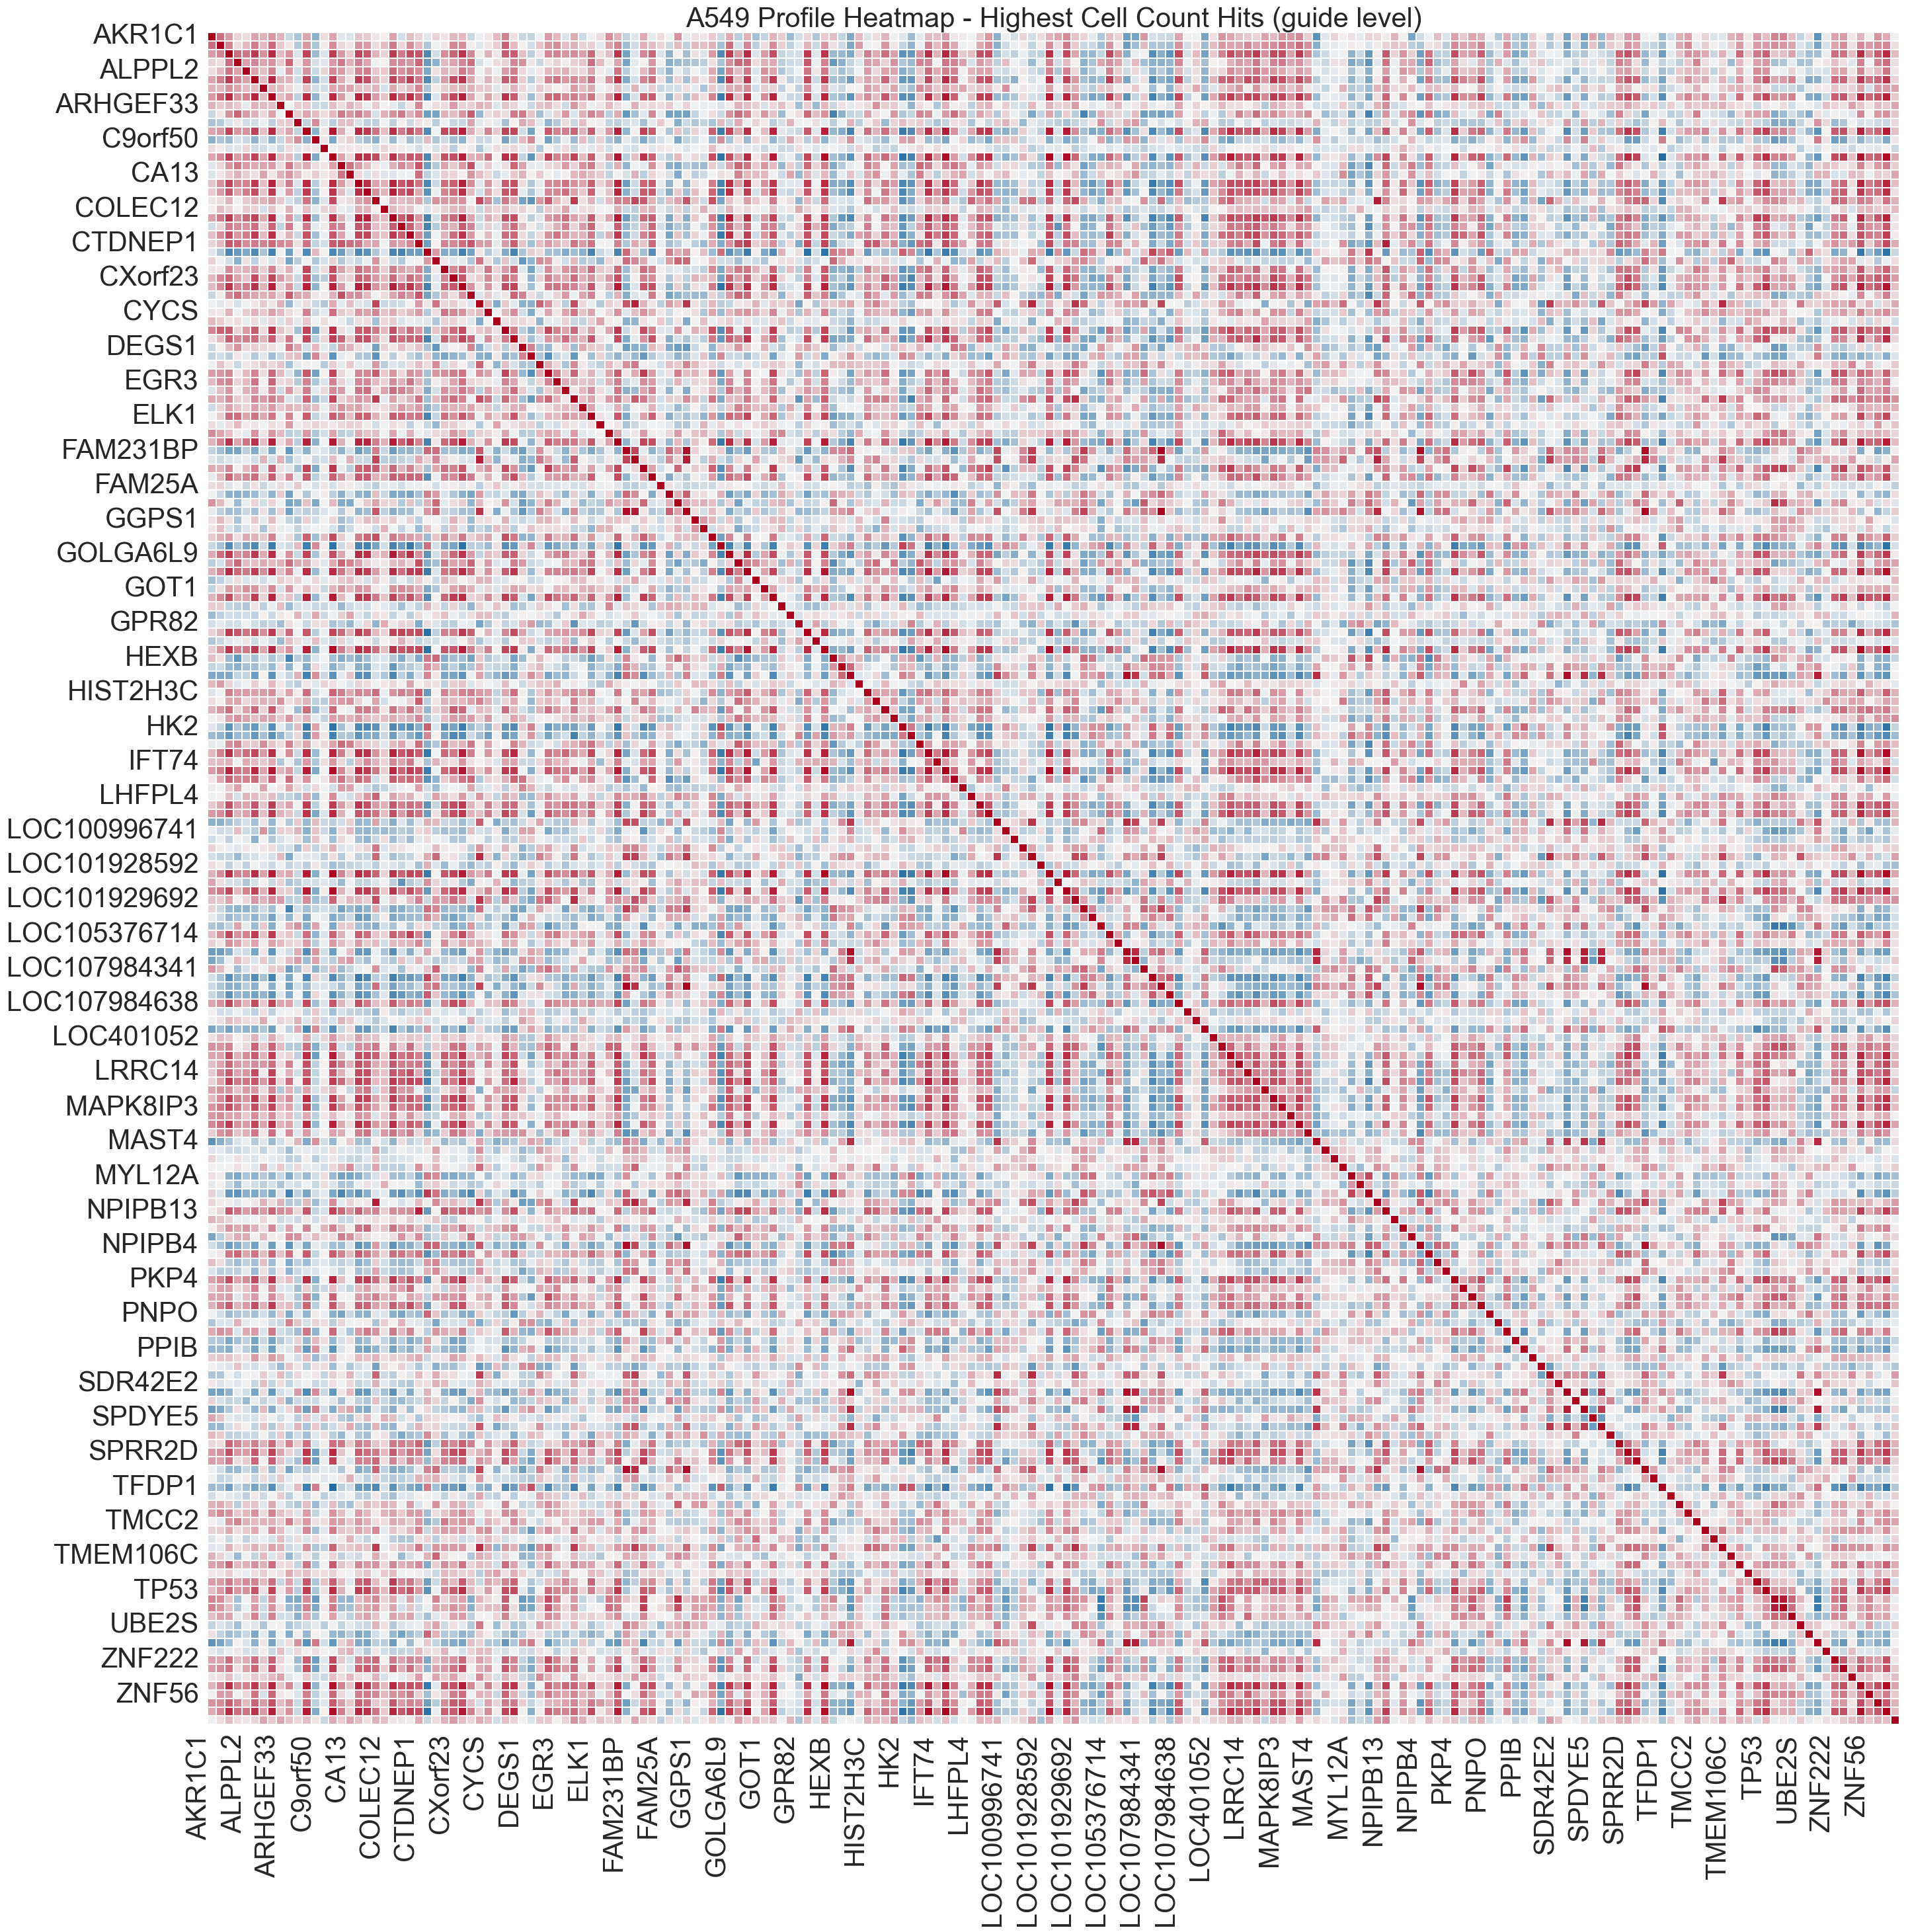

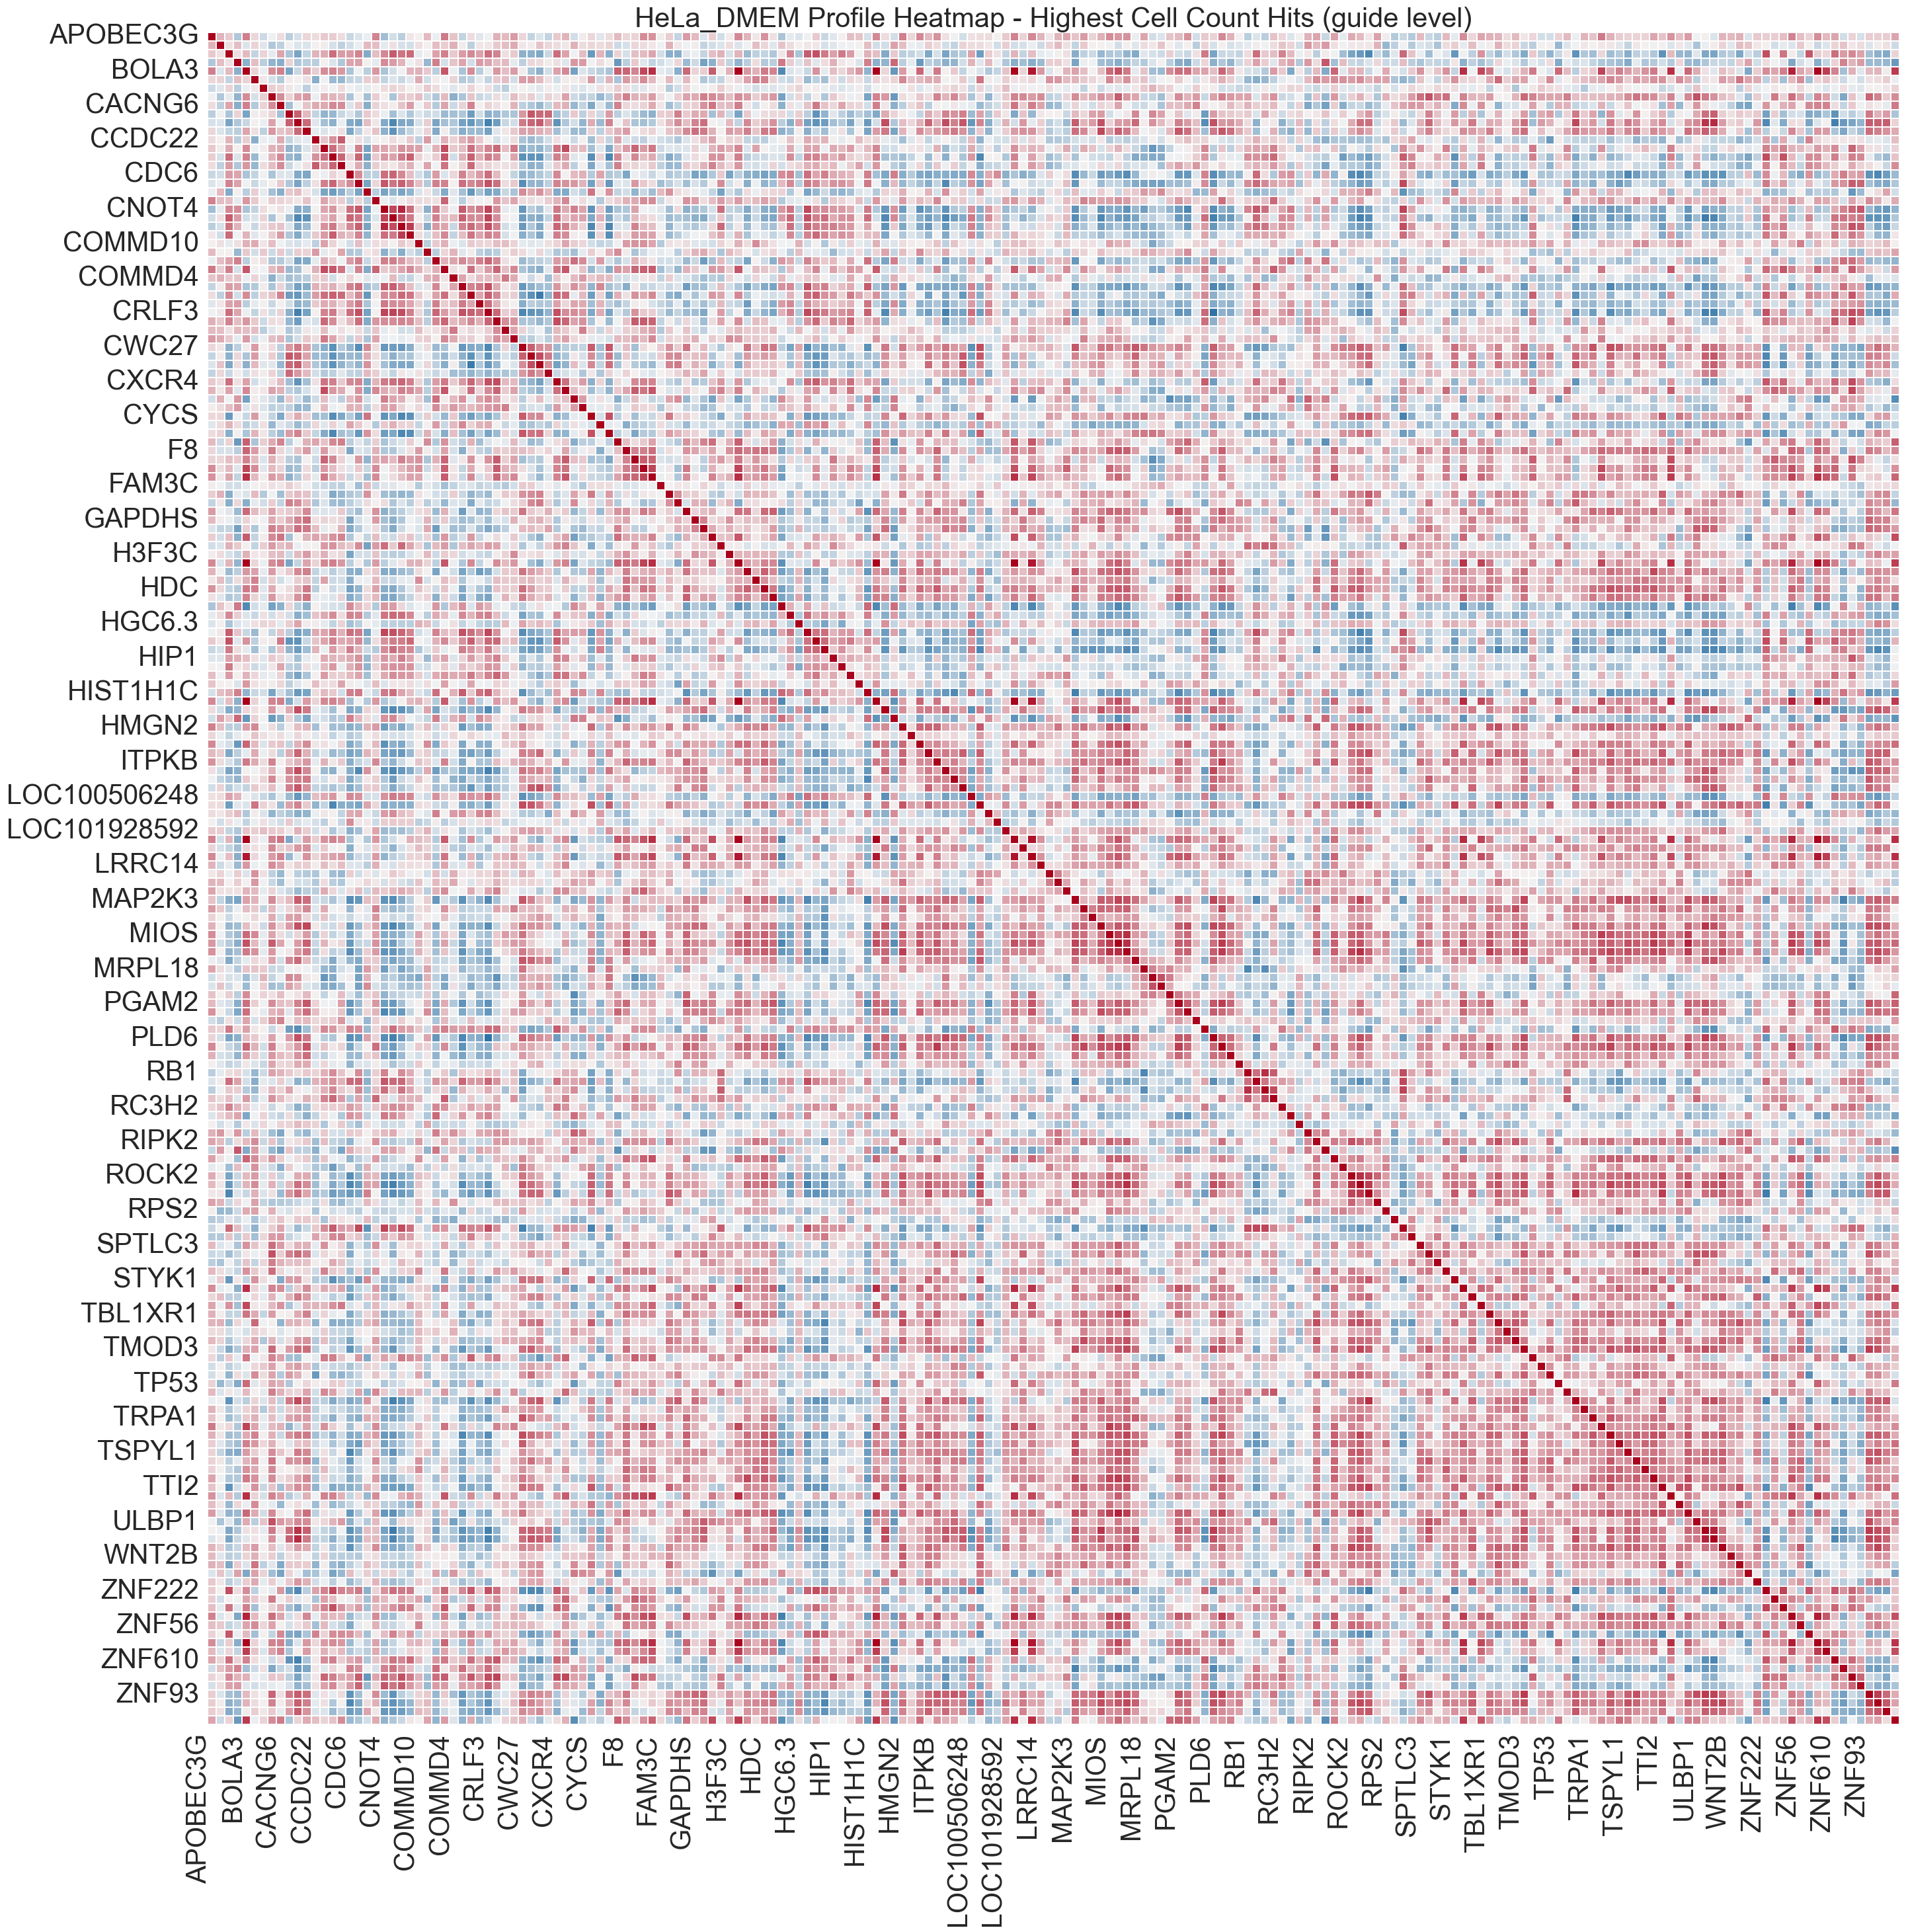

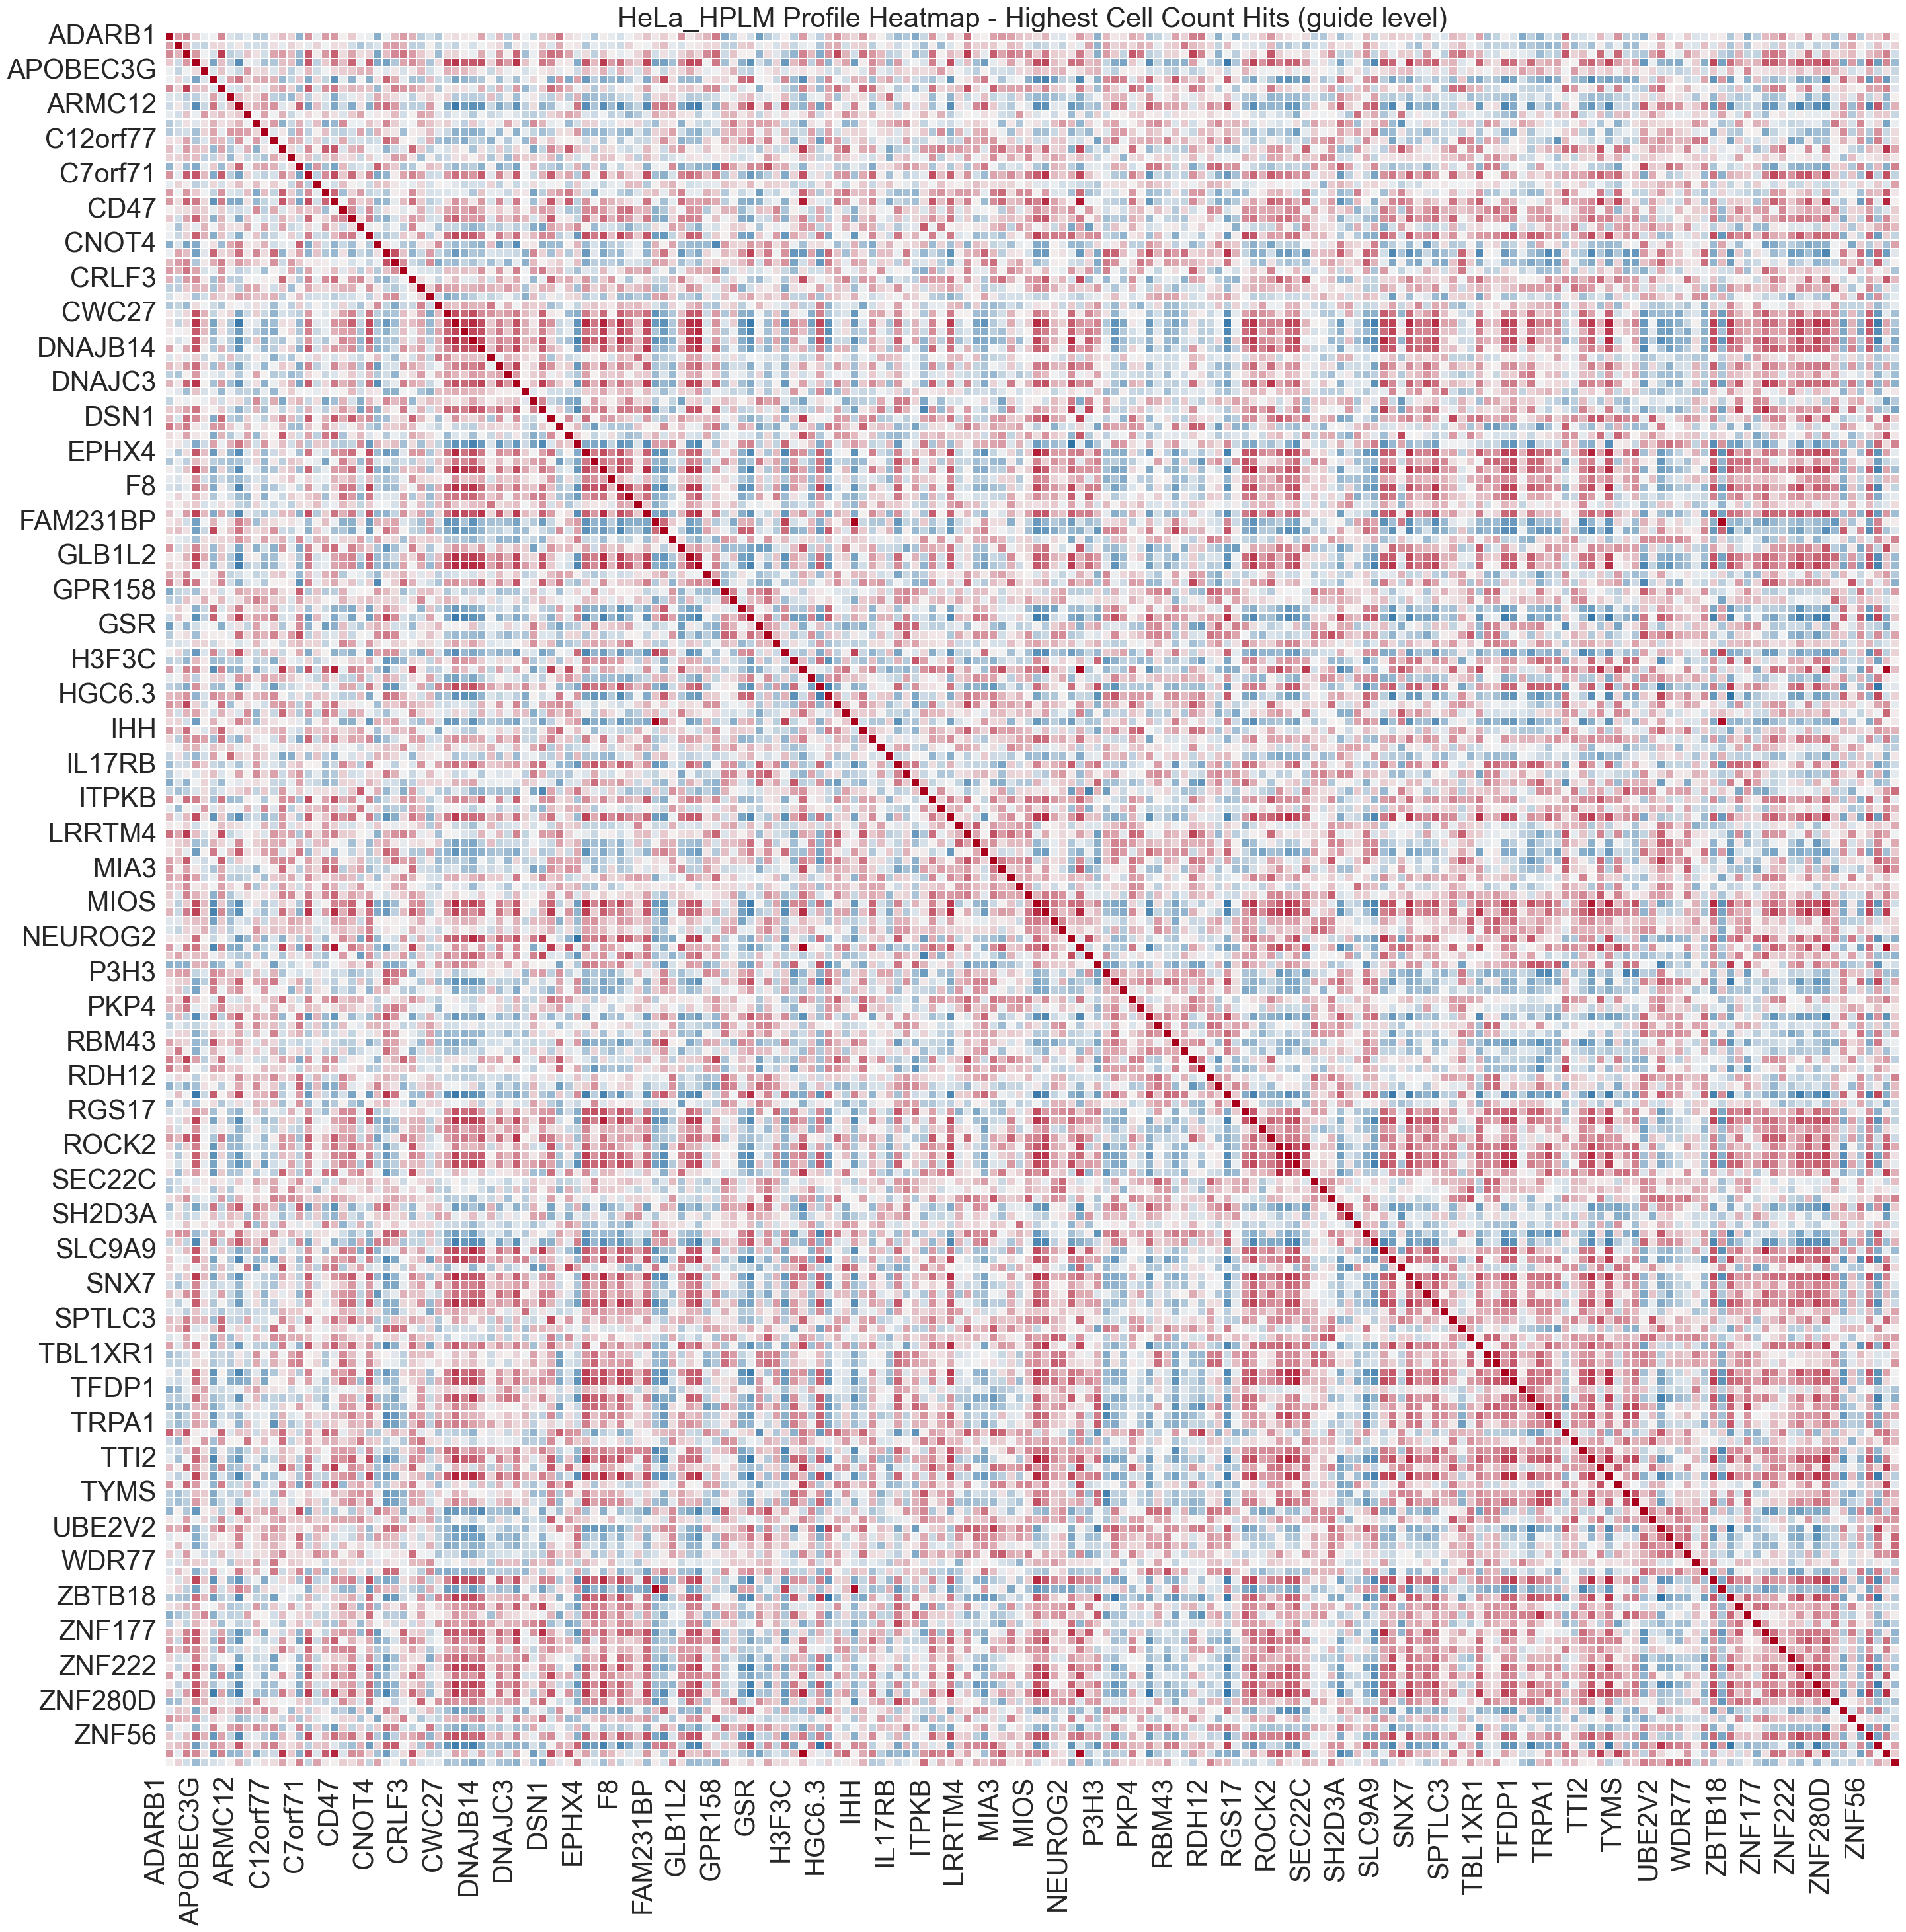

In [11]:
# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(counts, hit_list, profile_df, data_set, font_scale):
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    df = hit_counts.groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    geneswith4guides = df.loc[df['Metadata_Foci_Barcode_MatchedTo_Barcode']==4].index.to_list()
    hit_counts_with4guides = hit_counts.loc[hit_counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(geneswith4guides)]
    Top50_barcodes = hit_counts_with4guides.groupby('Metadata_Foci_Barcode_MatchedTo_Barcode').sum(numeric_only=True).nlargest(50,'Cell_Count').index.to_list()
    genes_list = hit_counts_with4guides.loc[hit_counts_with4guides['Metadata_Foci_Barcode_MatchedTo_Barcode'].isin(Top50_barcodes)]['Metadata_Foci_Barcode_MatchedTo_GeneCode'].to_list()
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - Highest Cell Count Hits (guide level)',
                       f'{data_set}_profile_heatmap_guide_level_highest_cell_count_hits.png',
                       font_scale)
    
draw_high_count_heat_maps(A549_counts, A549_hit_list, A549_pca_df, 'A549', 2.7)
draw_high_count_heat_maps(DMEM_counts, DMEM_hit_list, HeLa_DMEM_pca_df, 'HeLa_DMEM', 2.7)
draw_high_count_heat_maps(HPLM_counts, HPLM_hit_list, HeLa_HPLM_pca_df, 'HeLa_HPLM', 2.7)

50 genes A549 dataset


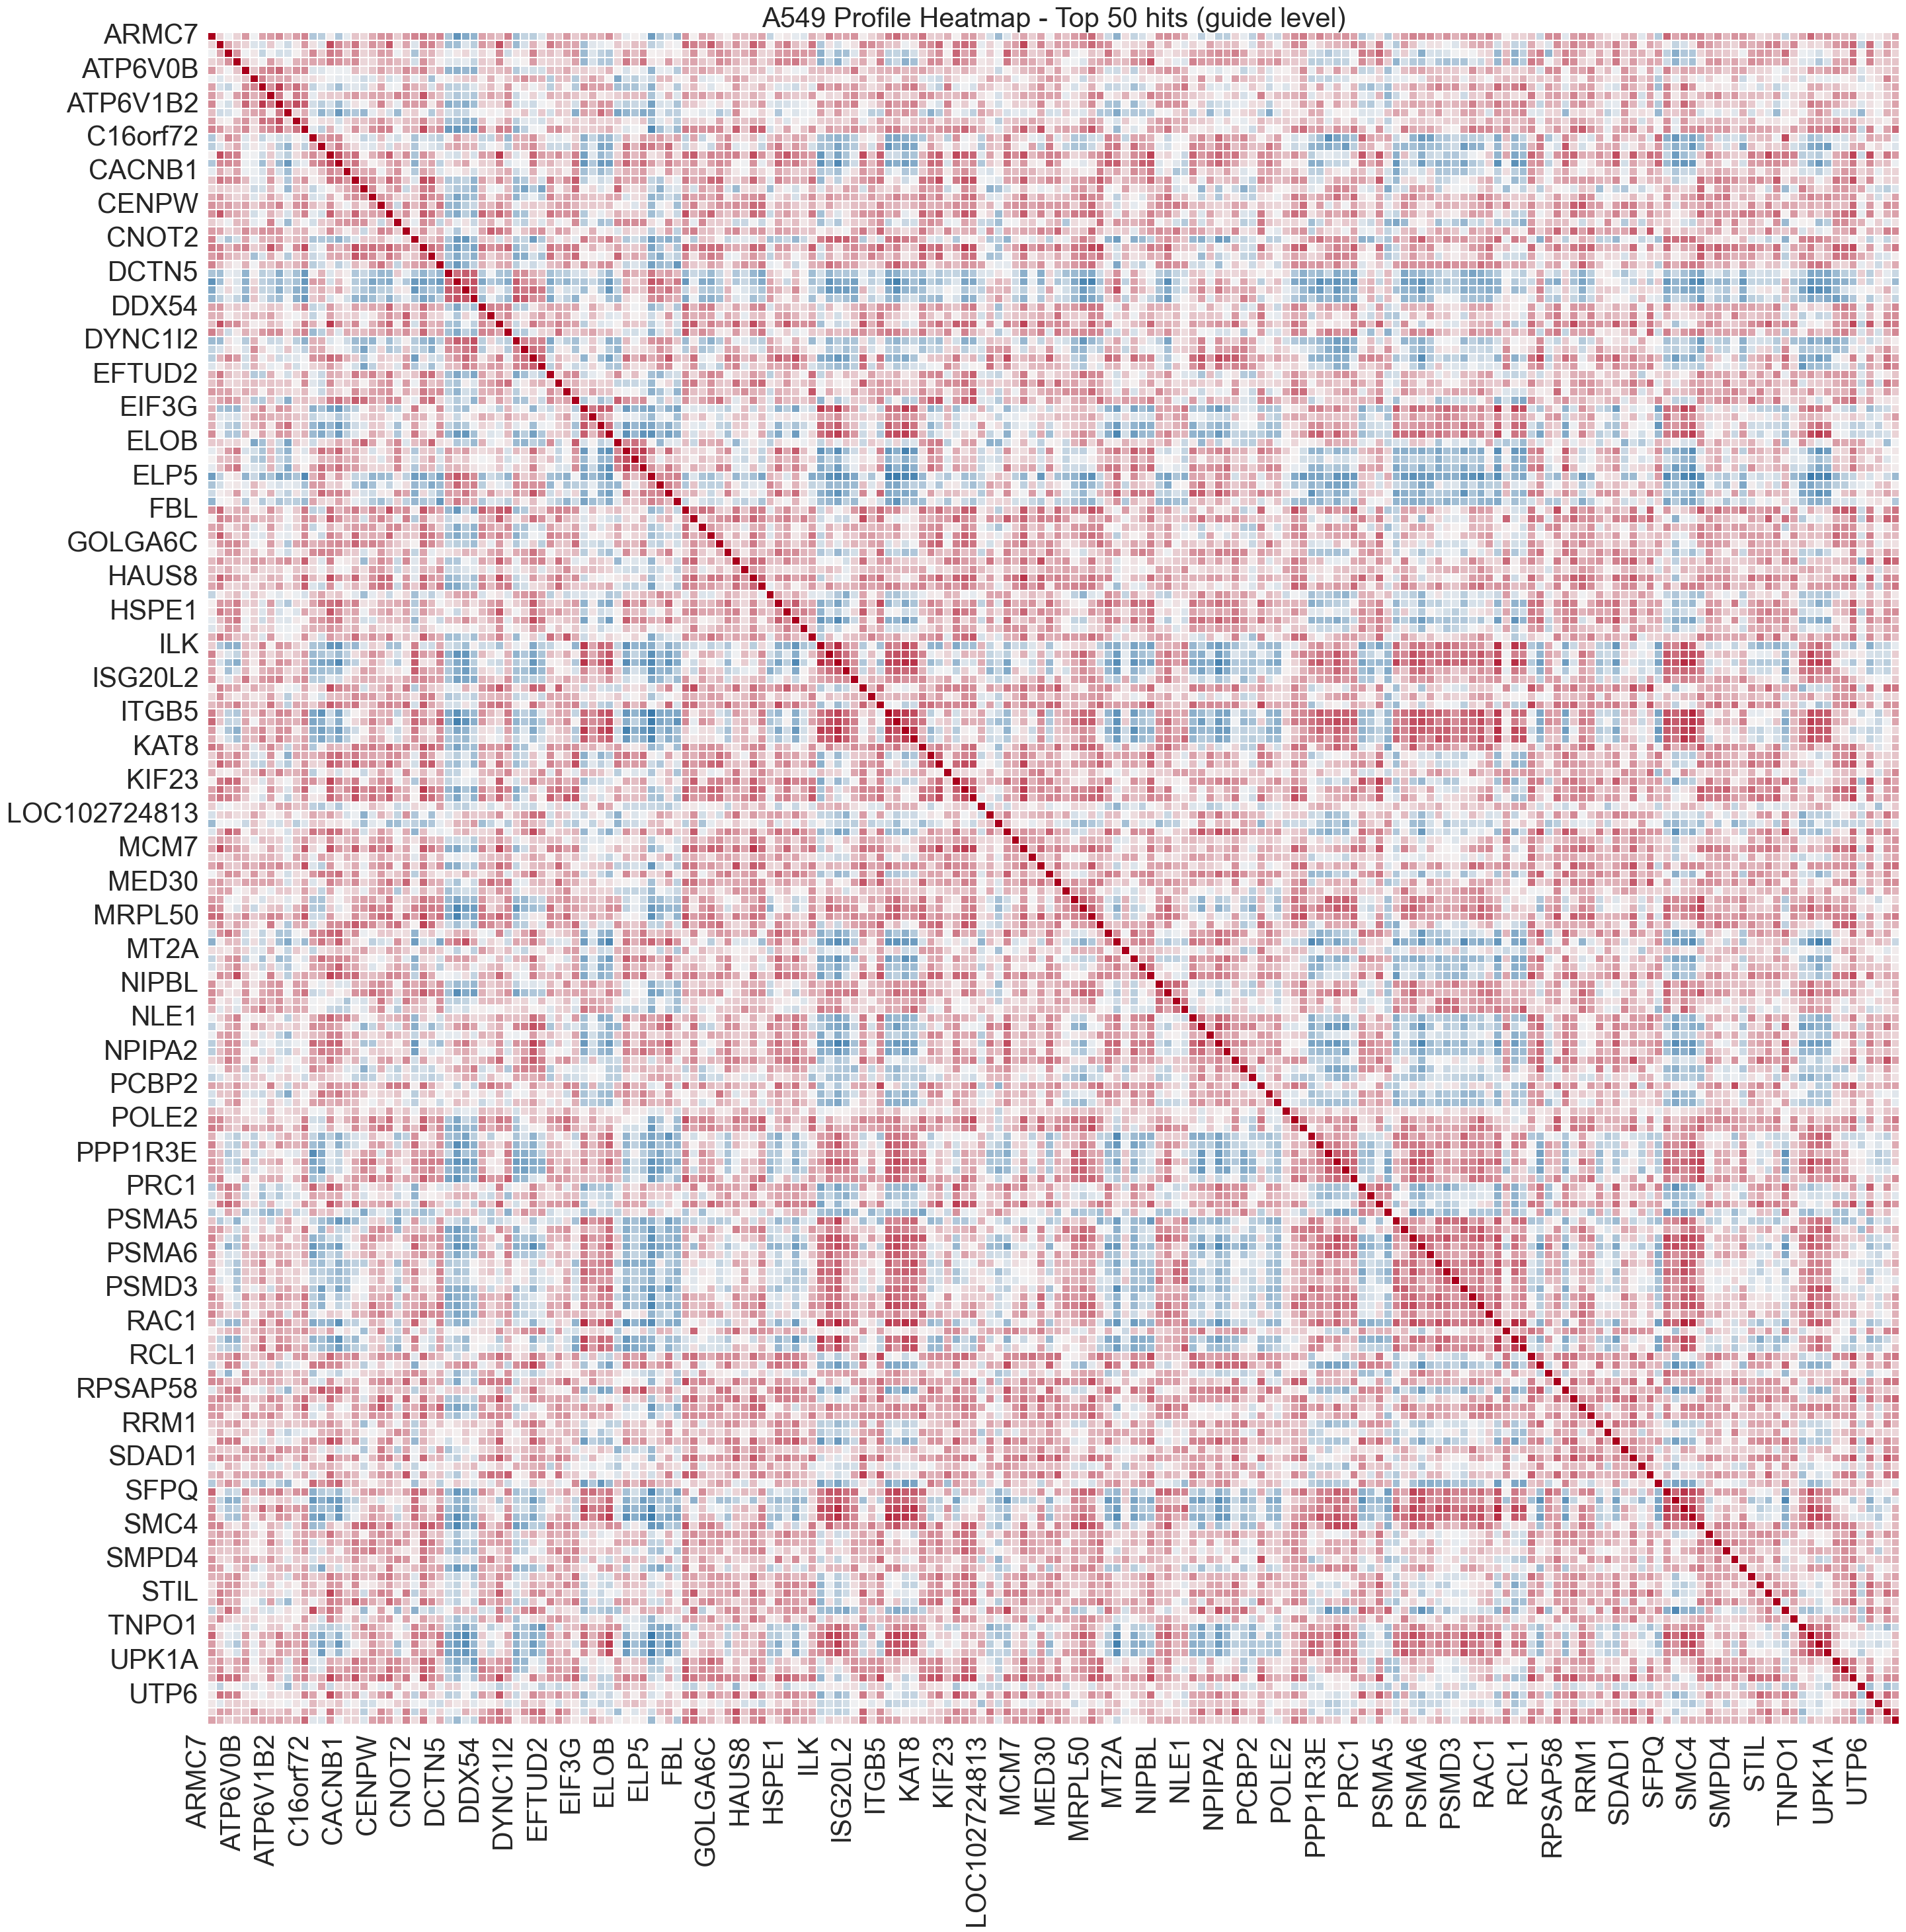

51 genes HeLa_DMEM dataset


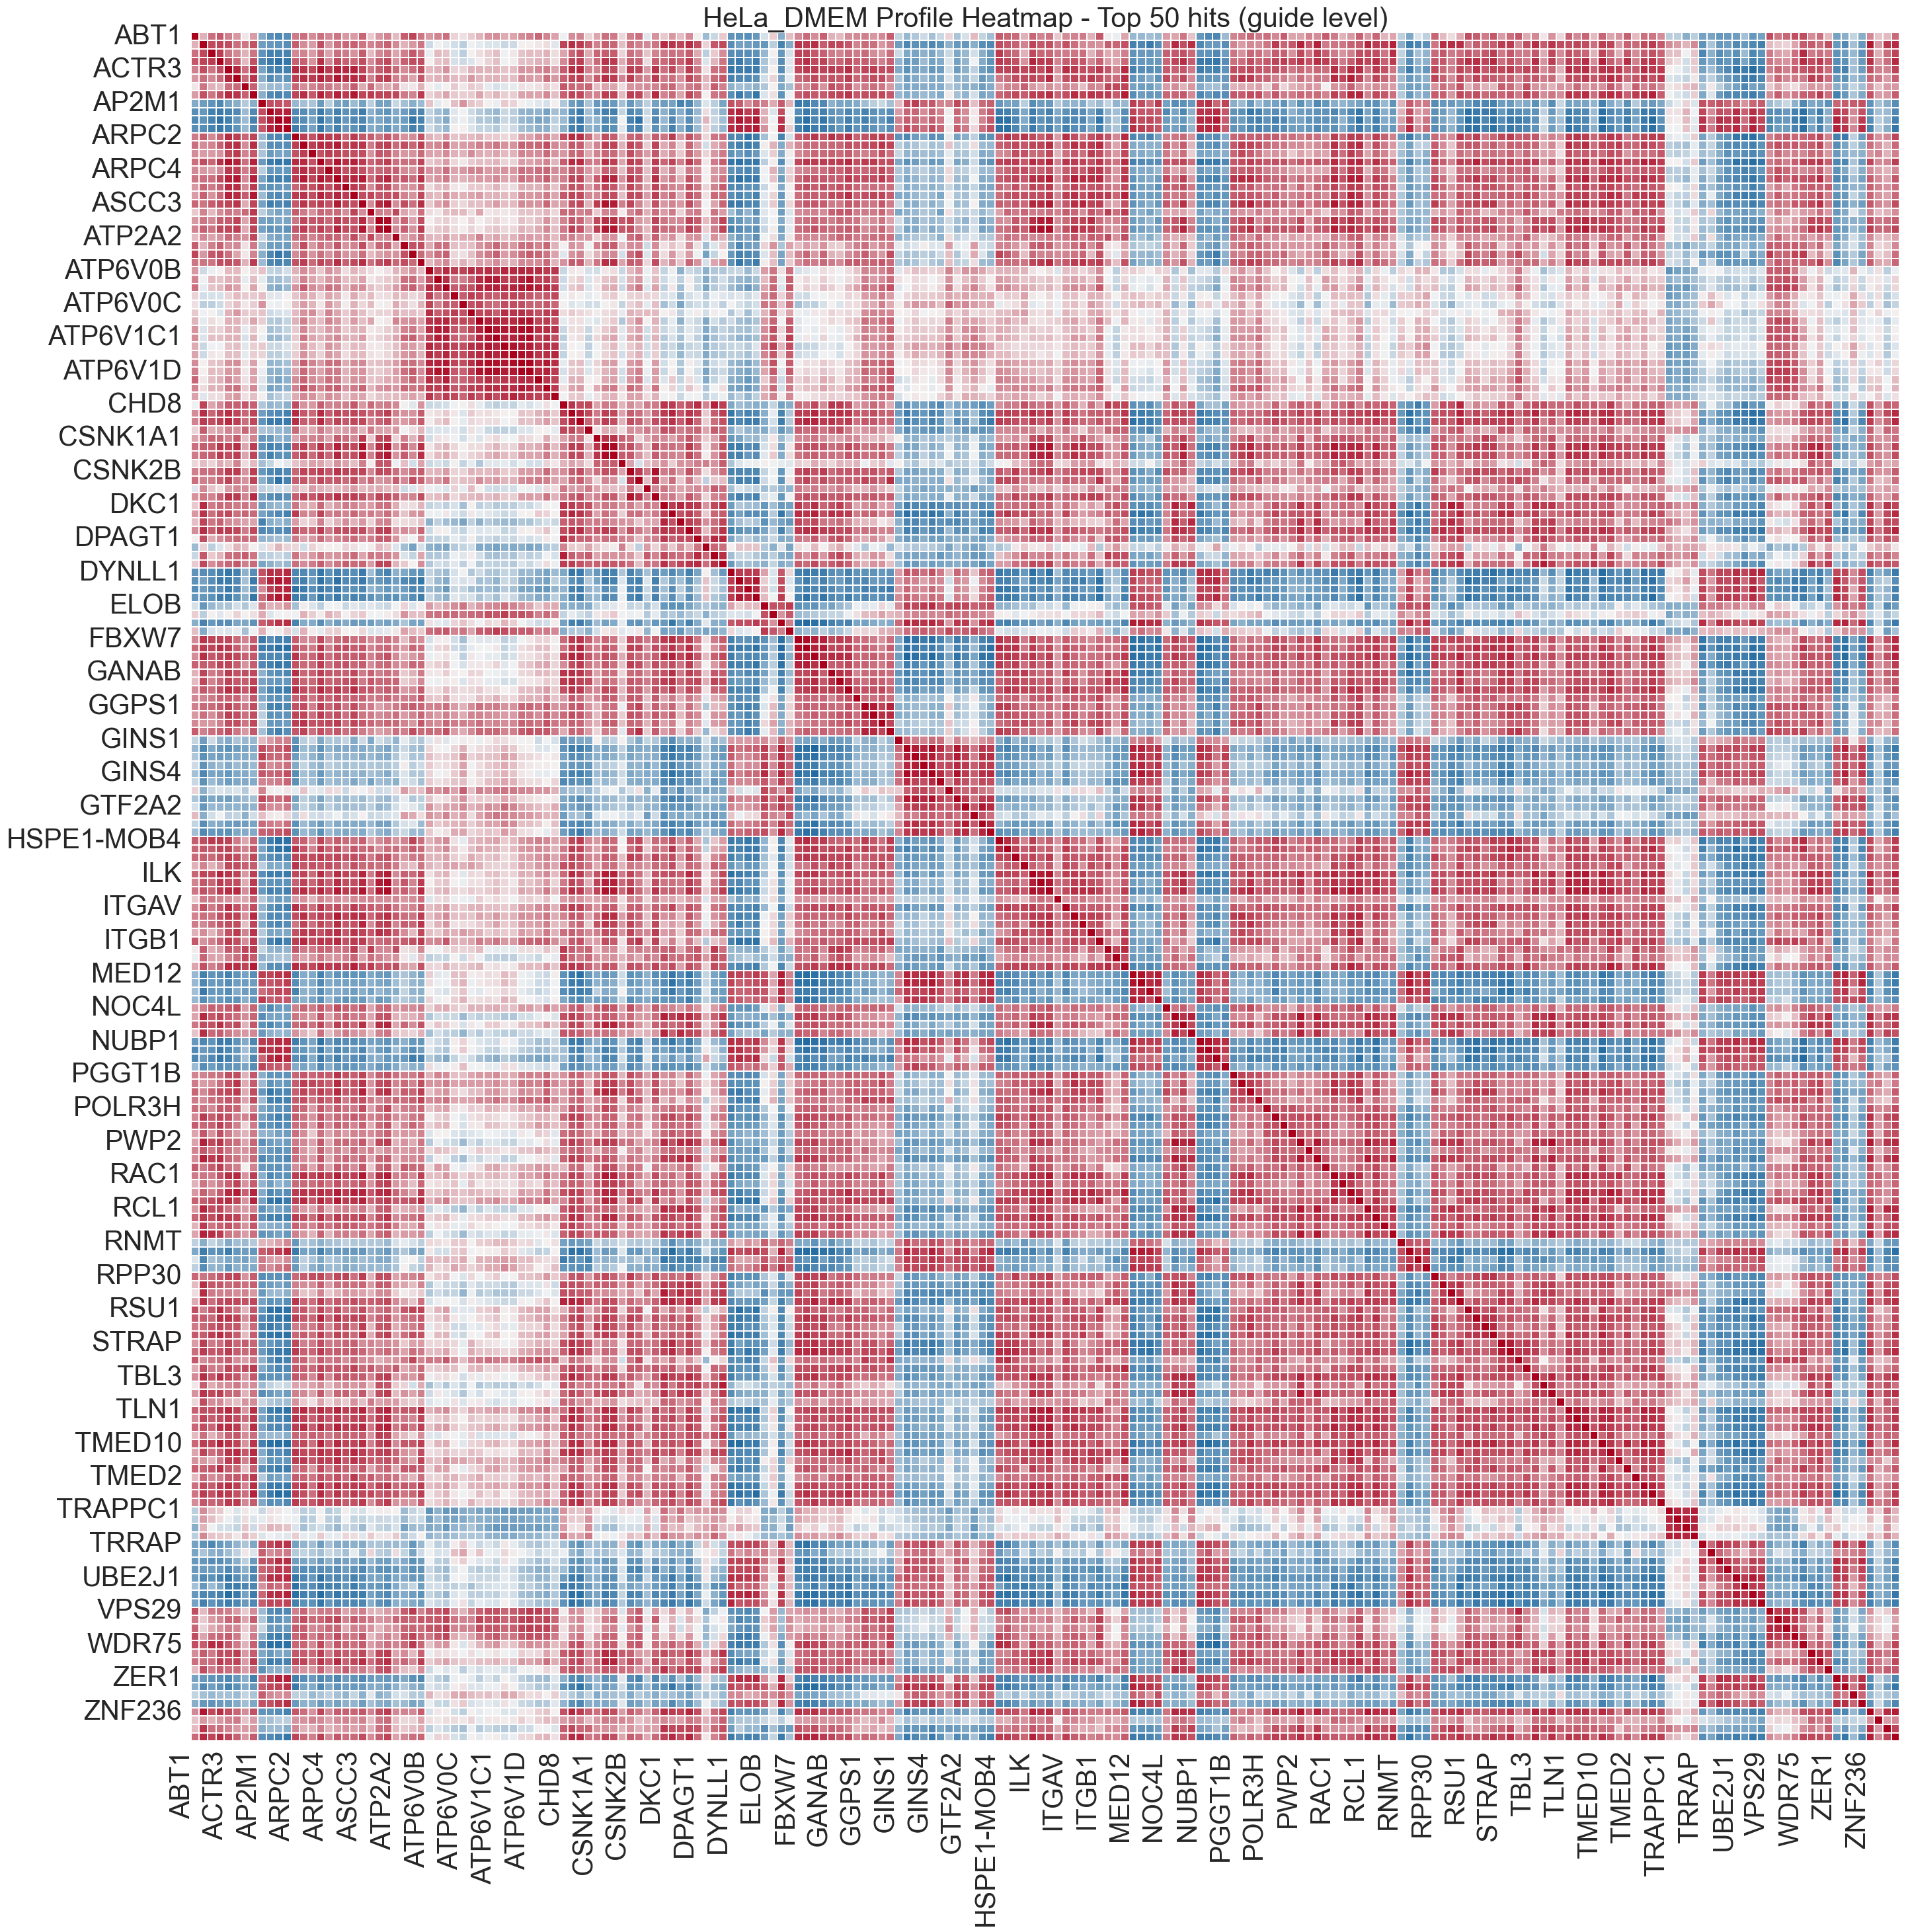

50 genes HeLa_HPLM dataset


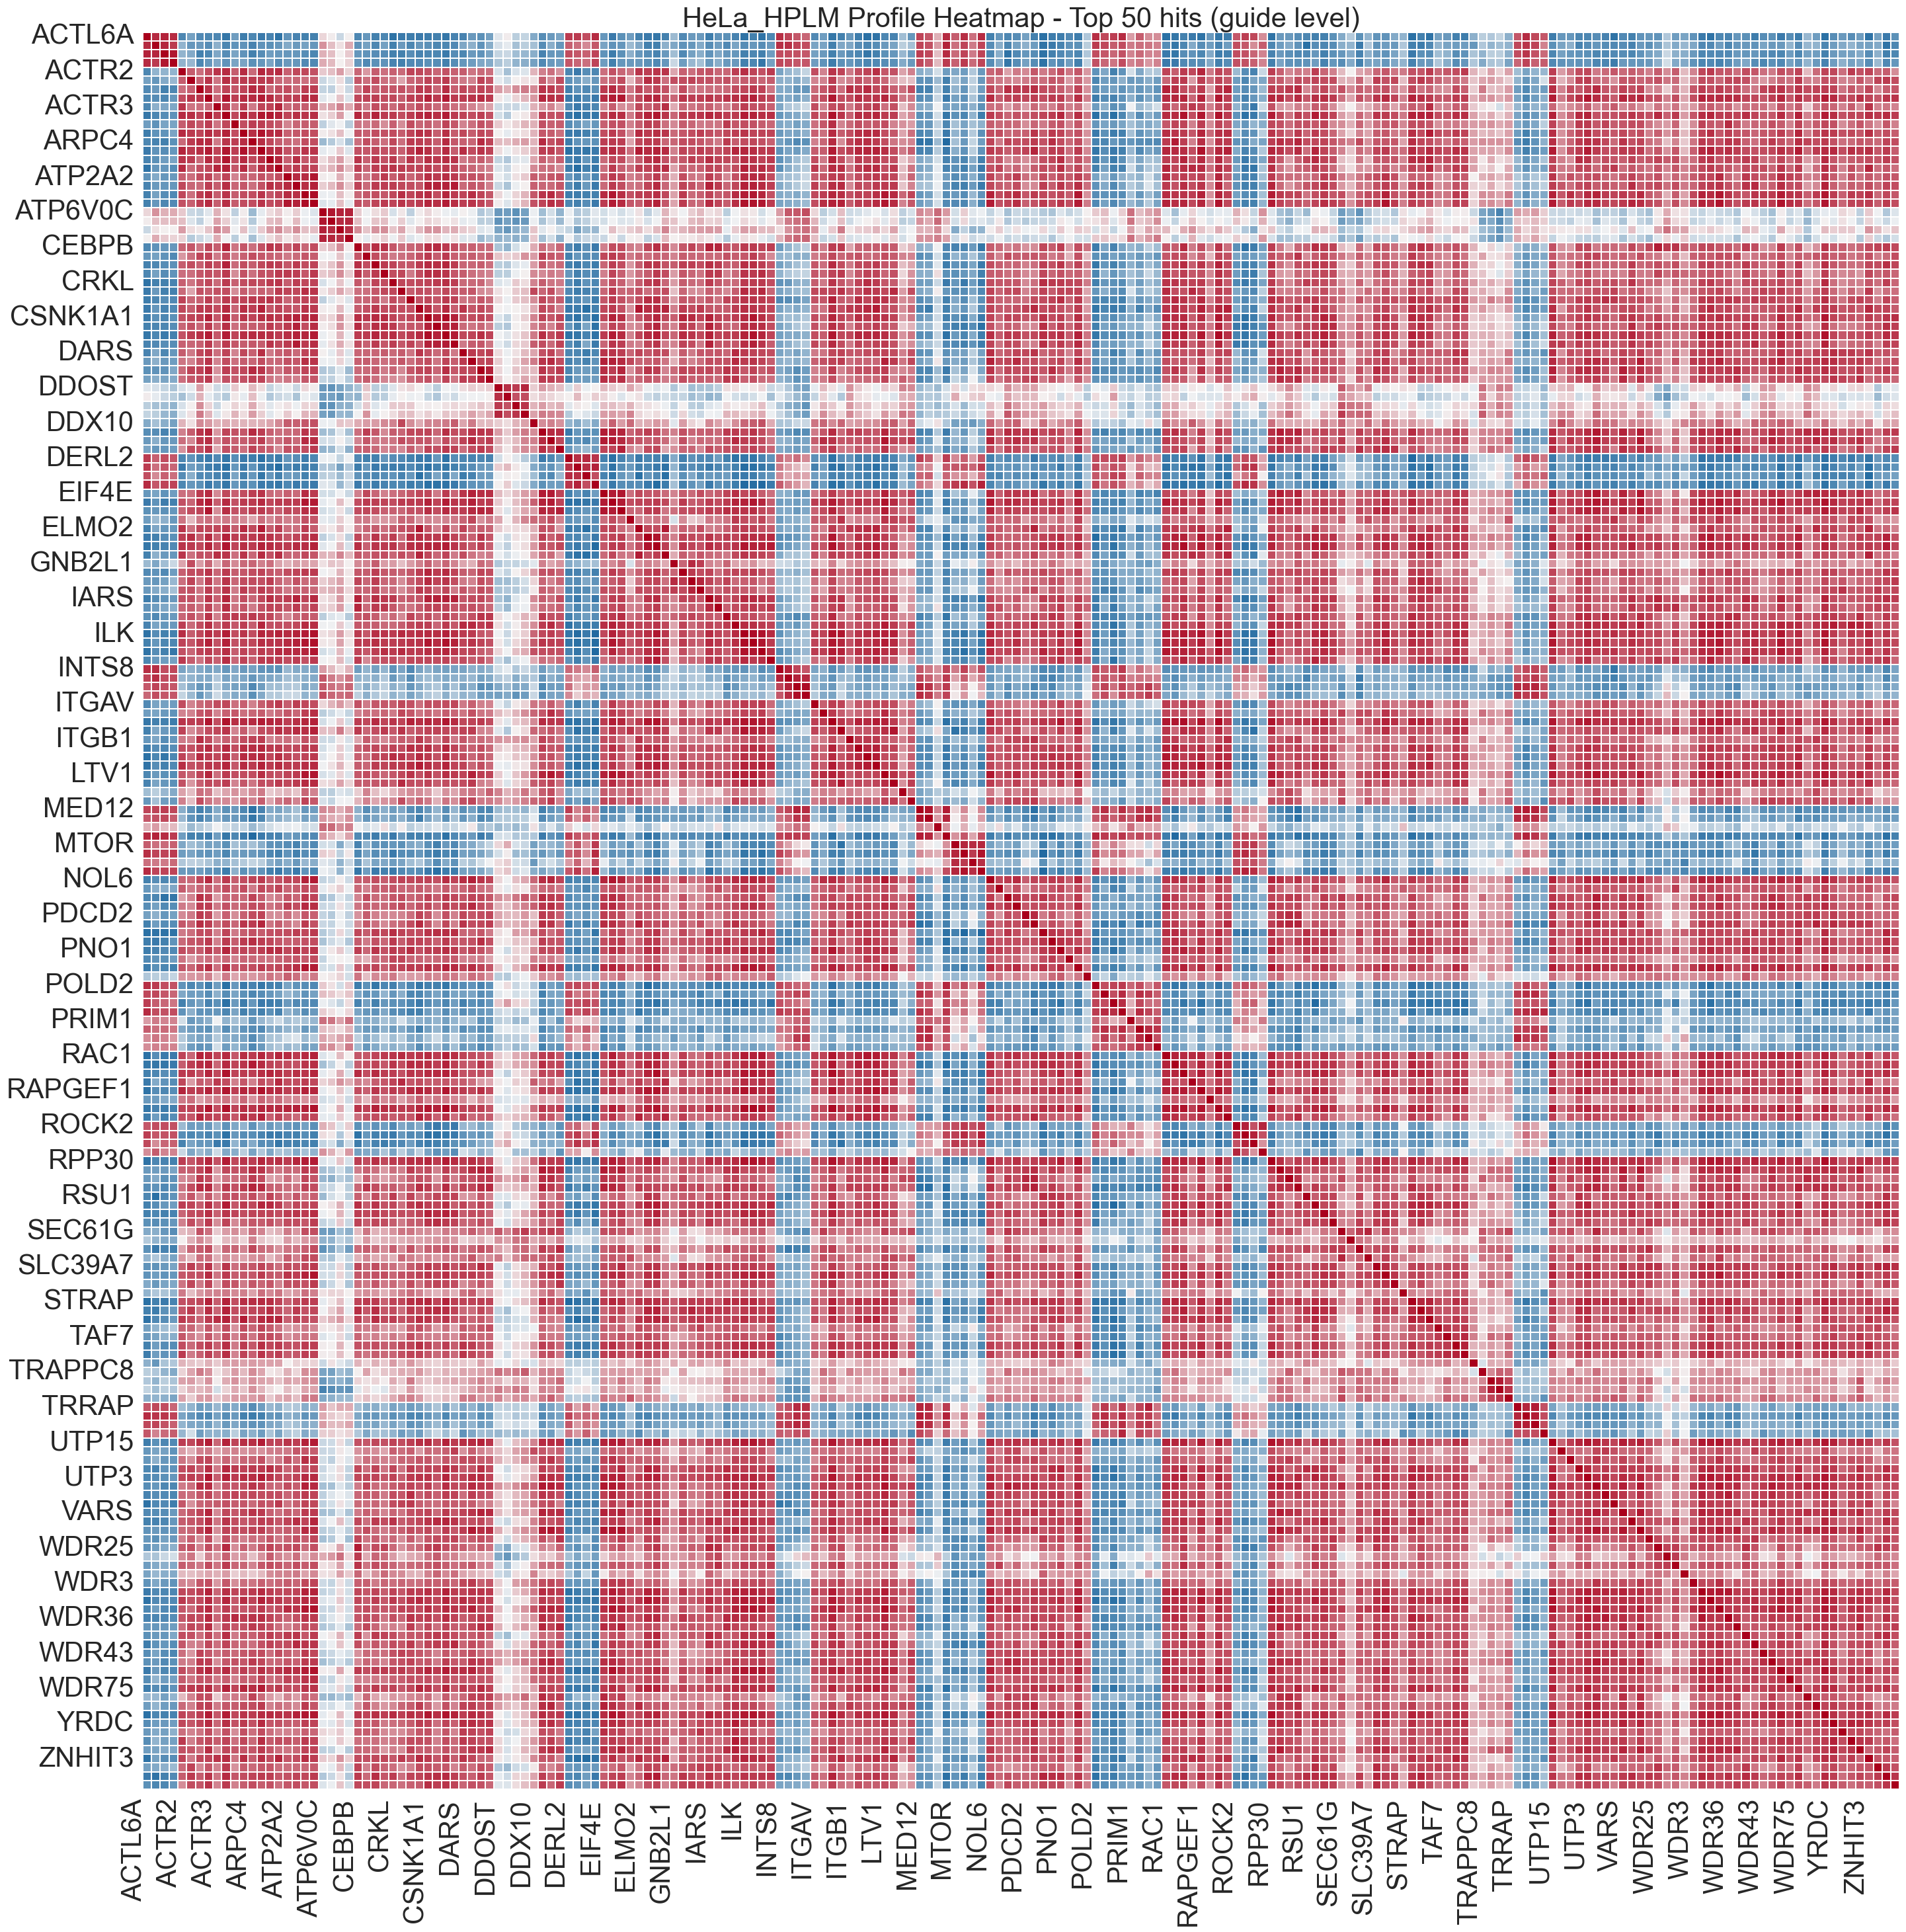

In [8]:
# Subset the data and draw heat-maps for guides with high signal
def draw_top_heat_maps(all_hits_df, profile_df, n_top, data_set, font_scale):
    for i in range(int(all_hits_df.Sum.max()),0,-1):
        genes_lst = list(all_hits_df.query(f"Sum > {i} ").Gene)
        if len(genes_lst) >= n_top:
            break
    print(f'{len(genes_lst)} genes {data_set} dataset')
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_lst)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - Top {n_top} hits (guide level)',
                       f'{data_set}_profile_heatmap_guide_level_top_{n_top}_hits.png',
                       font_scale)
    
draw_top_heat_maps(A549_all_hits, A549_pca_df, 50, 'A549', 2.7)
draw_top_heat_maps(DMEM_all_hits, HeLa_DMEM_pca_df, 50, 'HeLa_DMEM', 2.7)
draw_top_heat_maps(HPLM_all_hits, HeLa_HPLM_pca_df, 50, 'HeLa_HPLM', 2.7)


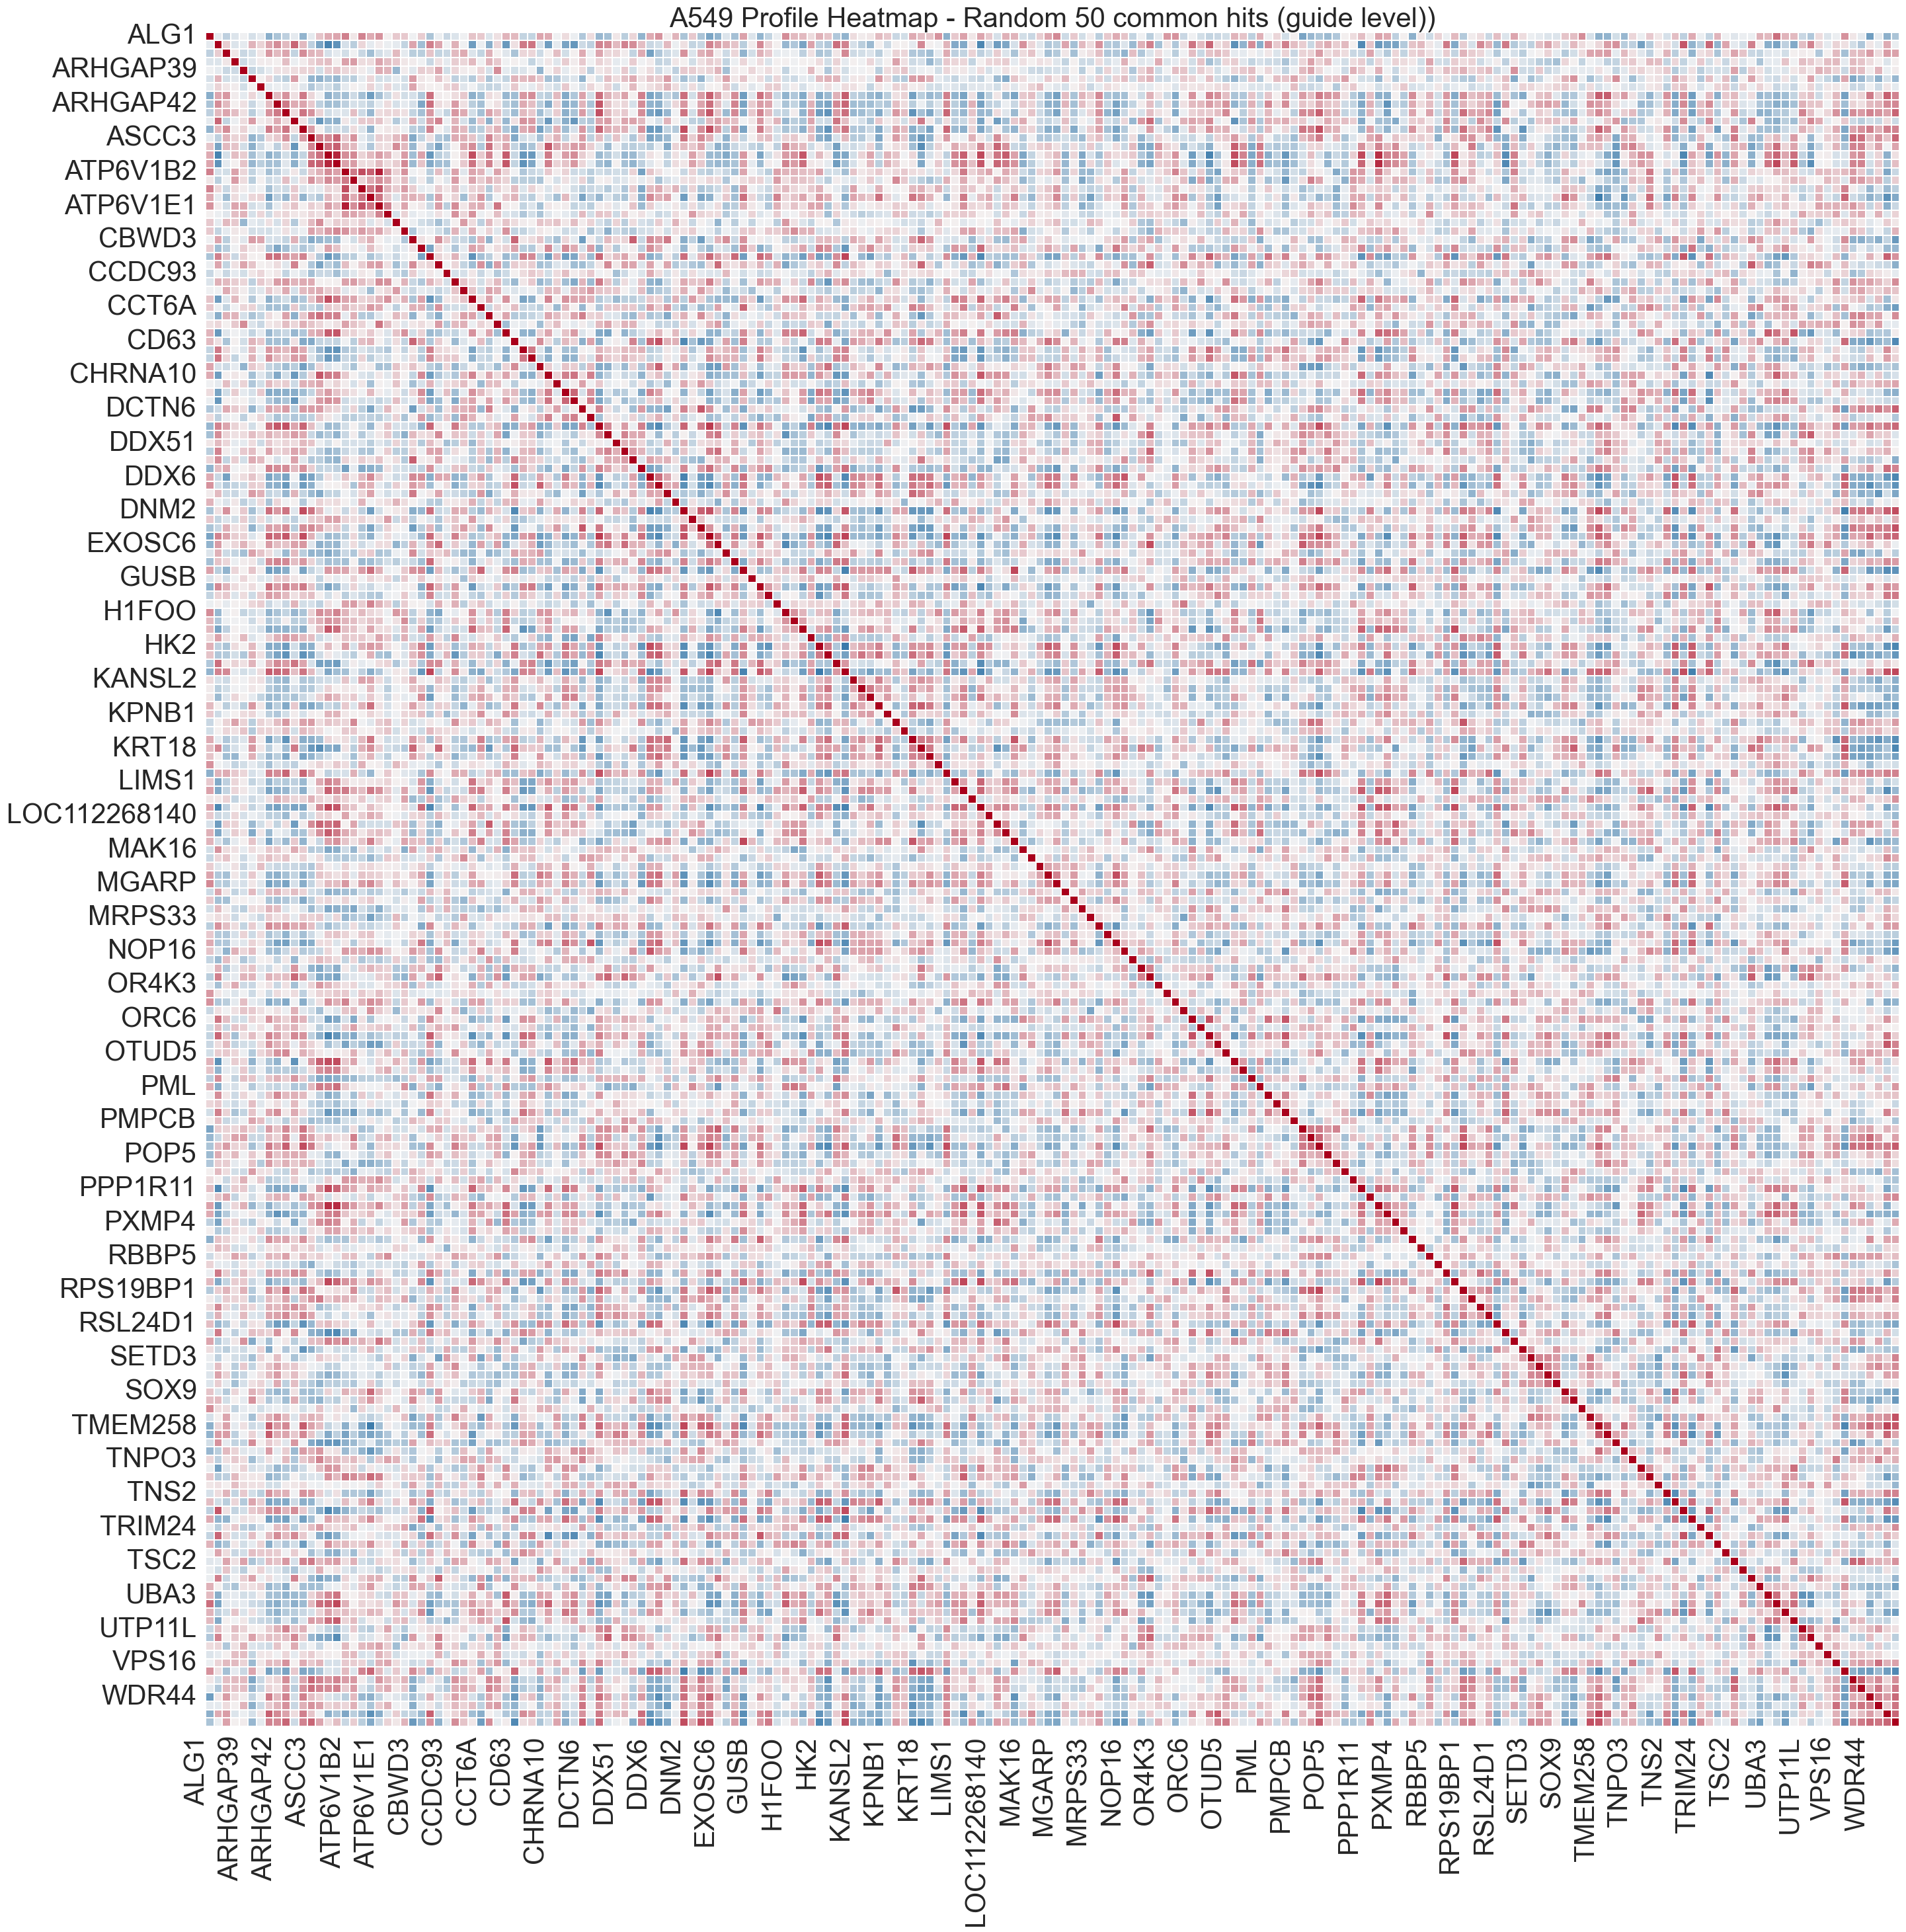

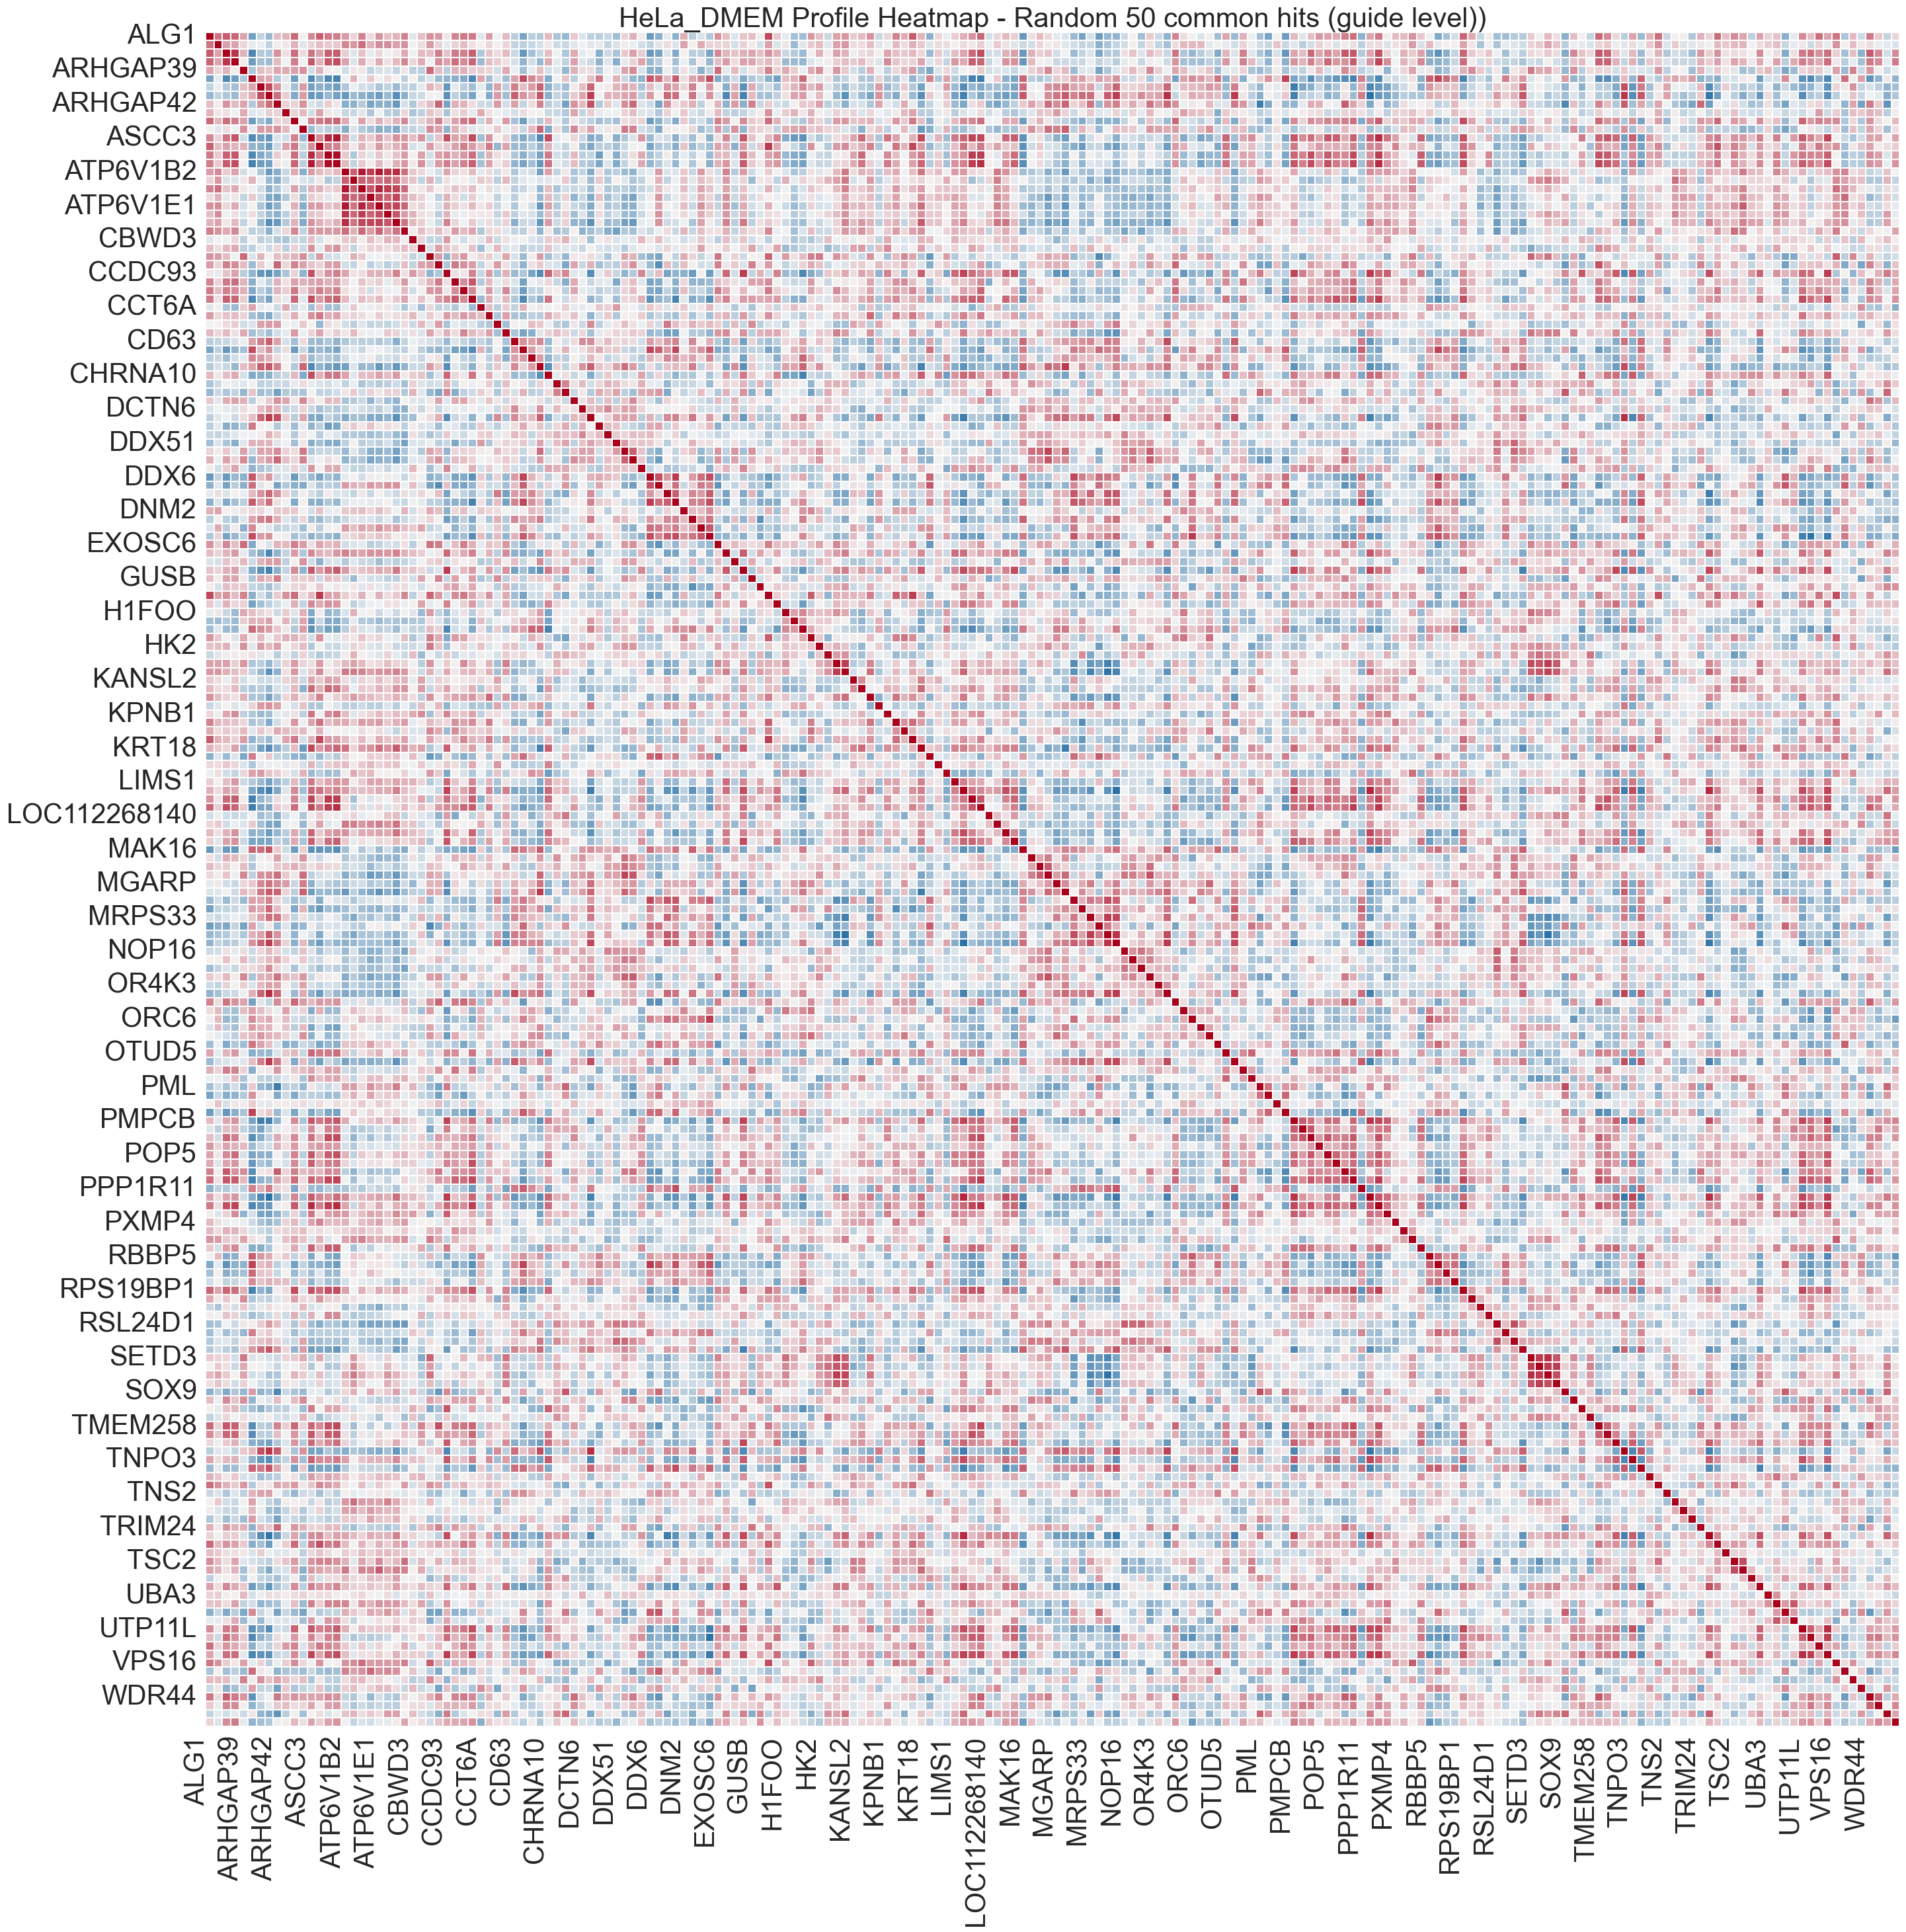

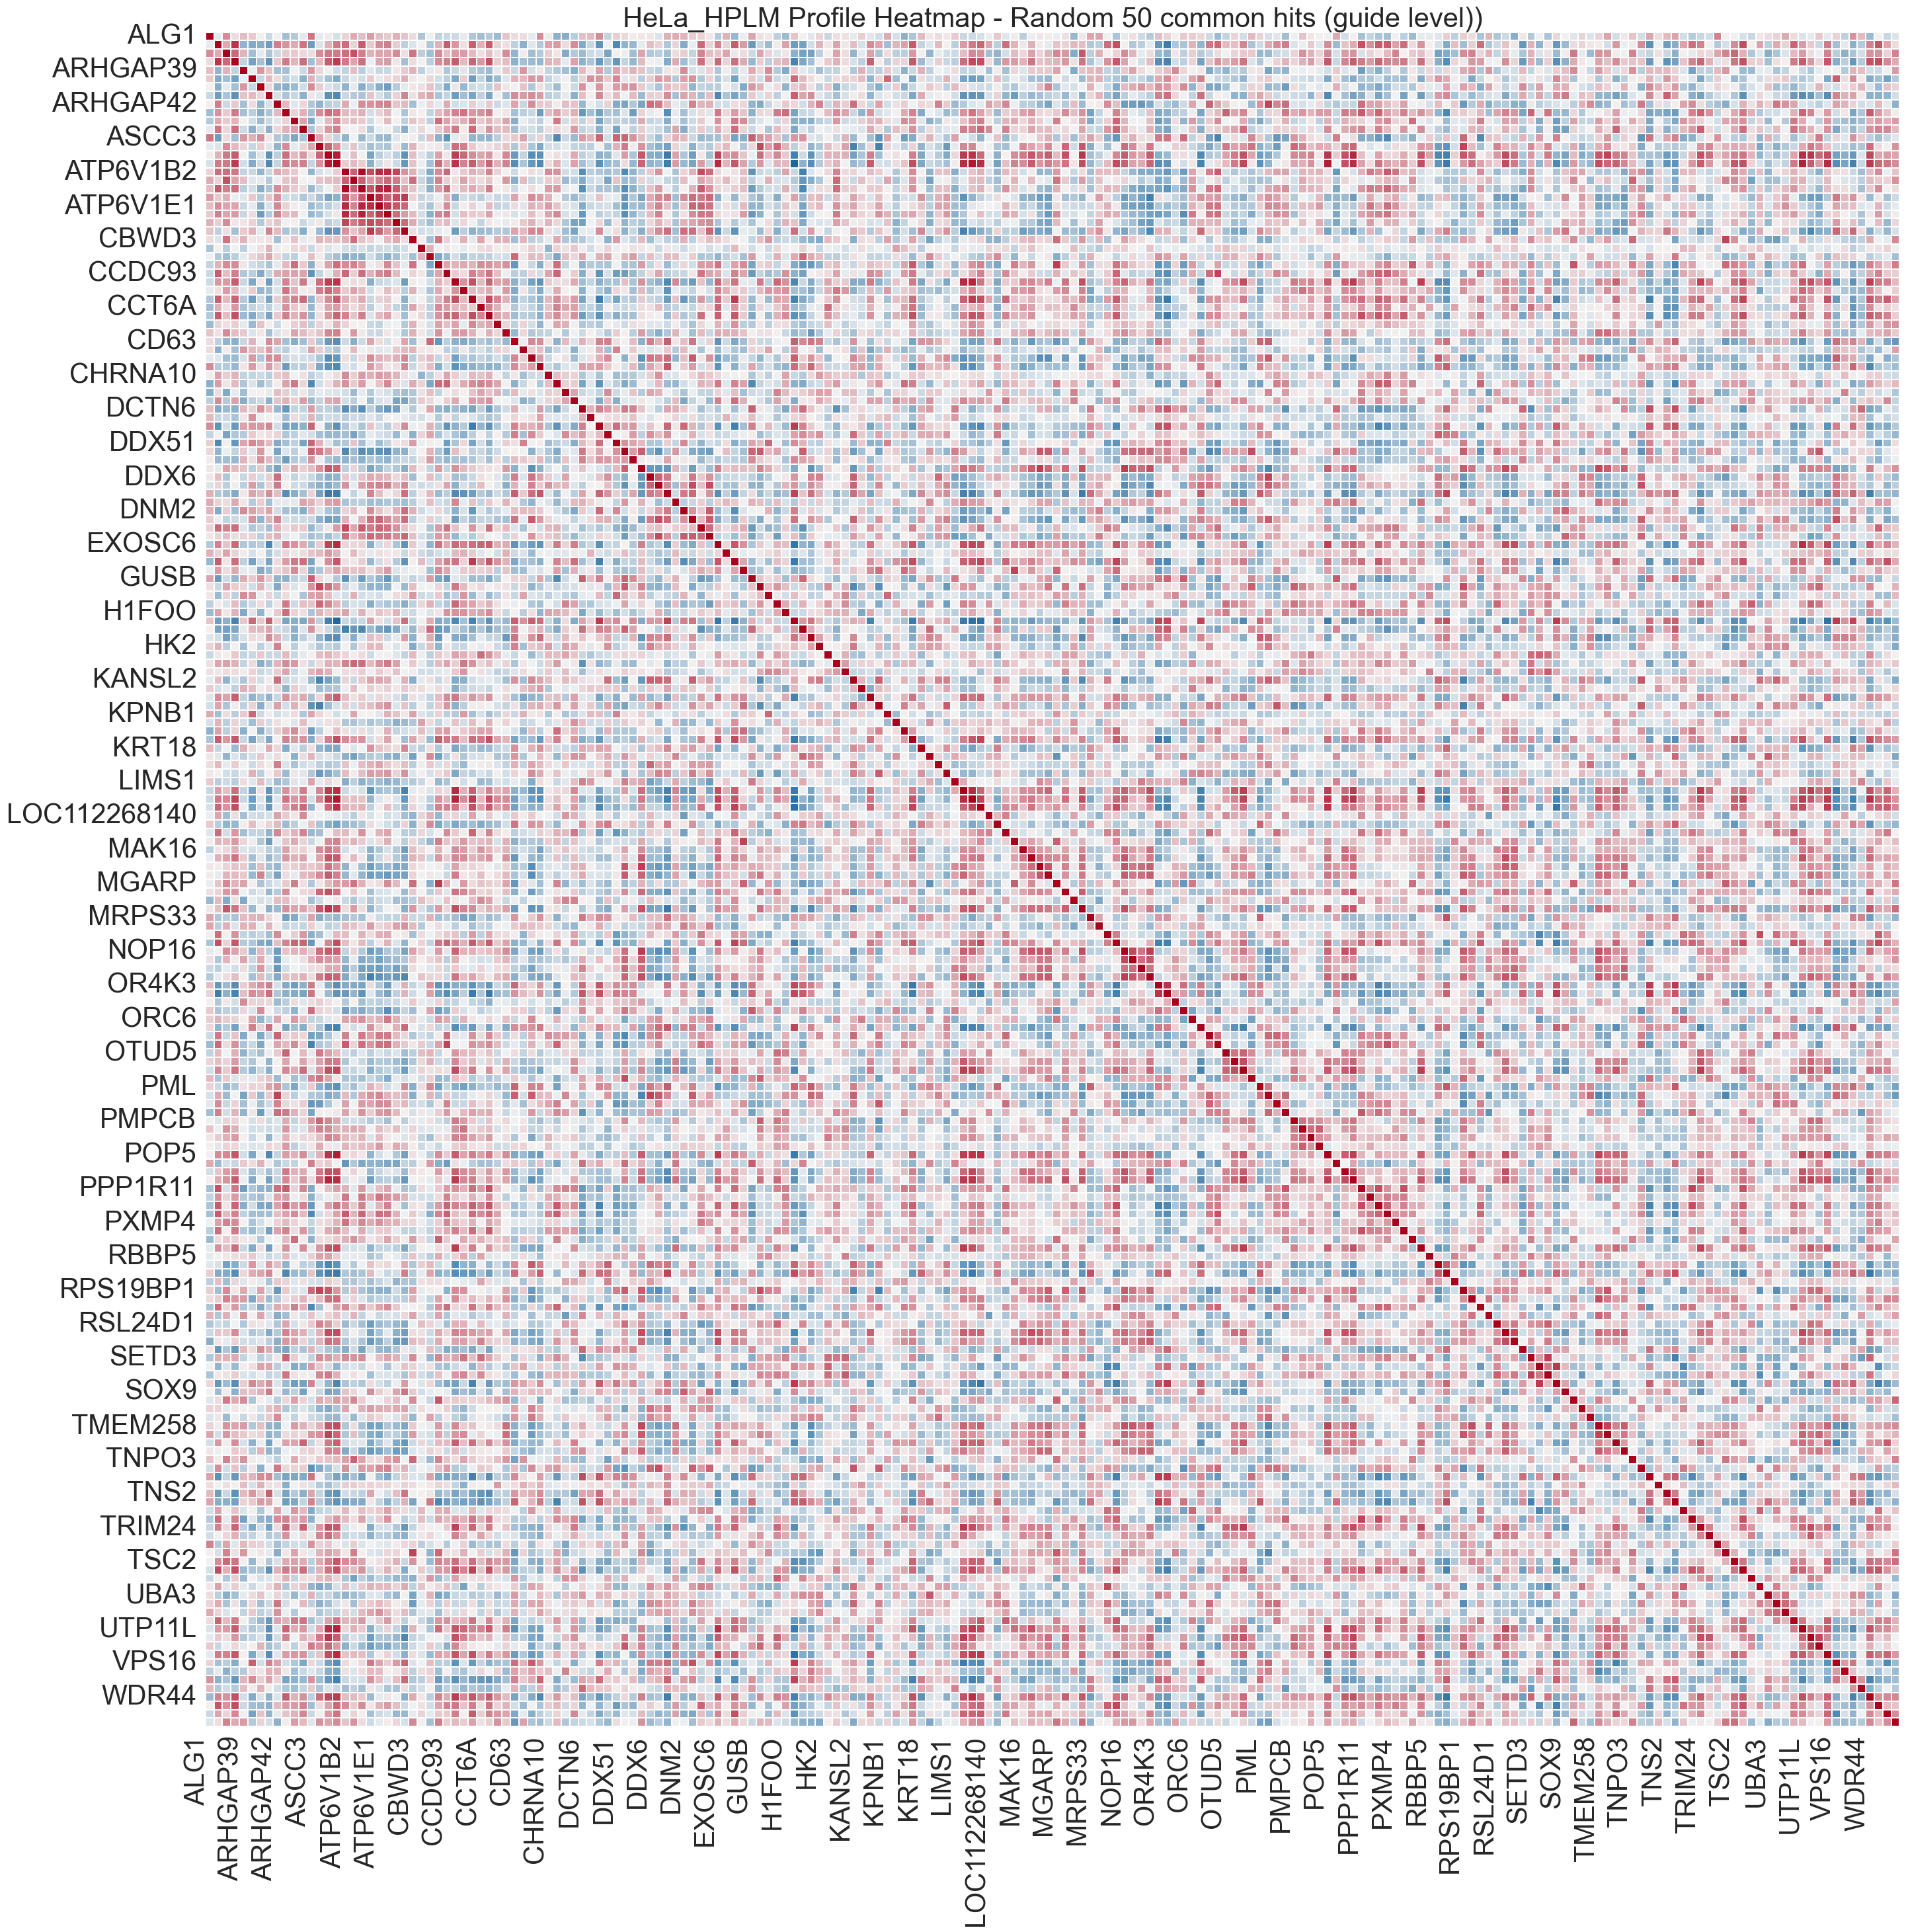

In [9]:
# Subset the data and draw heat-maps for guides from common hit list
def draw_functional_heat_maps(genes_lst, profile_df, data_set, font_scale):
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_lst)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - Random 50 common hits (guide level))',
                       f'{data_set}_profile_heatmap_guide_level_random_50_common_hits.png',
                       font_scale)

common_hits = [i for i in A549_hit_list if i in DMEM_hit_list and i in HPLM_hit_list]
random.seed(10) 
random_common_hits = sample(common_hits,50)
draw_functional_heat_maps(random_common_hits, A549_pca_df, 'A549', 2.7)
draw_functional_heat_maps(random_common_hits, HeLa_DMEM_pca_df, 'HeLa_DMEM', 2.7)
draw_functional_heat_maps(random_common_hits, HeLa_HPLM_pca_df, 'HeLa_HPLM', 2.7)